In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import statsmodels.api as sm
import datetime
import sklearn
import mne
import os
import requests
import warnings
np.random.seed(2025)

%matplotlib inline

In [2]:
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# @title Data loading
alldat = np.load(r'C:\Users\Administrator\Desktop\compneuro\nma_face\data\faceshouses.npz', allow_pickle=True)['dat']

# select just one of the recordings here.
dat1 = alldat[1][1]

print(dat1.keys())

dict_keys(['stim_id', 'stim_cat', 'stim_noise', 't_on', 't_off', 'key_press', 'V', 'categories', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [4]:
def create_mne_raw_object(session_data, sfreq):
    """
    Creates a complete MNE Raw object from the session data, including
    channel info, montage, and stimulus annotations.

    Args:
        session_data (dict): The dictionary loaded by load_ecog_data.
        sfreq (int): The sampling frequency of the data.

    Returns:
        mne.io.RawArray: A fully configured MNE Raw object.
    """
    print("Creating complete MNE Raw object...")
    # --- Create the basic Raw object ---
    data = session_data['V'].T
    n_channels = data.shape[0]
    ch_names = [f"ECOG_{i+1:03}" for i in range(n_channels)]
    ch_types = ['ecog'] * n_channels
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(data, info)

    # --- Add electrode locations (montage) ---
    locs = session_data['locs']
    ch_pos = {ch_names[i]: locs[i] for i in range(n_channels)}
    montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='mni_tal')
    raw.set_montage(montage)
    
    # --- Add stimulus onsets as annotations ---
    print("Adding stimulus annotations...")
    onsets_in_seconds = session_data['t_on'] / sfreq
    durations = np.full_like(onsets_in_seconds, 0.4)  # Duration is 400ms
    descriptions = [f"[{int(cat)}]" for cat in np.array(session_data['stim_cat']).flatten()]
    annotations = mne.Annotations(onset=onsets_in_seconds,
                                  duration=durations,
                                  description=descriptions)
    raw.set_annotations(annotations)
    
    print("Complete MNE Raw object created.")
    return raw


datamain=create_mne_raw_object(dat1,1000)

Creating complete MNE Raw object...
Creating RawArray with float64 data, n_channels=50, n_times=672280
    Range : 0 ... 672279 =      0.000 ...   672.279 secs
Ready.
Adding stimulus annotations...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_19308\2298860071.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Complete MNE Raw object created.


In [5]:
# Create MNE epochs from t_on for dat1, using stimulus category (house=1, face=2)
info = mne.create_info(ch_names=[f"ECOG_{i+1:03}" for i in range(50)], sfreq=1000, ch_types=['ecog']*50)
raw = mne.io.RawArray(dat1['V'].T, info)
times = np.array(dat1['t_on']).reshape(-1, 1)
zeros = np.zeros((len(times), 1))
# Extract numbers from strings (e.g., "[1]" → 1)
categories = np.array(dat1['stim_cat'])
categories = categories.astype(int)  # Ensure column shape

# Combine into events array (must be integers)
events = np.column_stack([times, zeros, categories]).astype(int)
# Define event_id with meaningful labels (optional)
event_id = {
    'category_1': 1,  # if events[:,2] contains 1
    'category_2': 2,   # if events[:,2] contains 2
}
# Create epochs
epochs = mne.Epochs(
    datamain,
    events=events,
    event_id=event_id,
    tmin=-0.2,
    tmax=0.6,
    baseline=(None, None),
    preload=True
)

Creating RawArray with float64 data, n_channels=50, n_times=672280
    Range : 0 ... 672279 =      0.000 ...   672.279 secs
Ready.
Not setting metadata
630 matching events found
Setting baseline interval to [-0.2, 0.6] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 630 events and 801 original time points ...
0 bad epochs dropped


Using matplotlib as 2D backend.


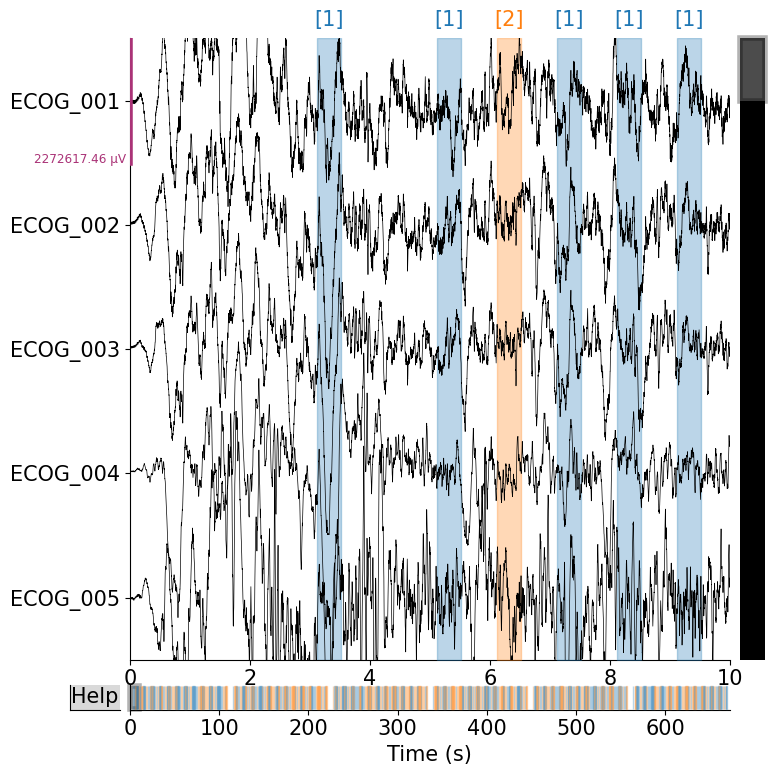

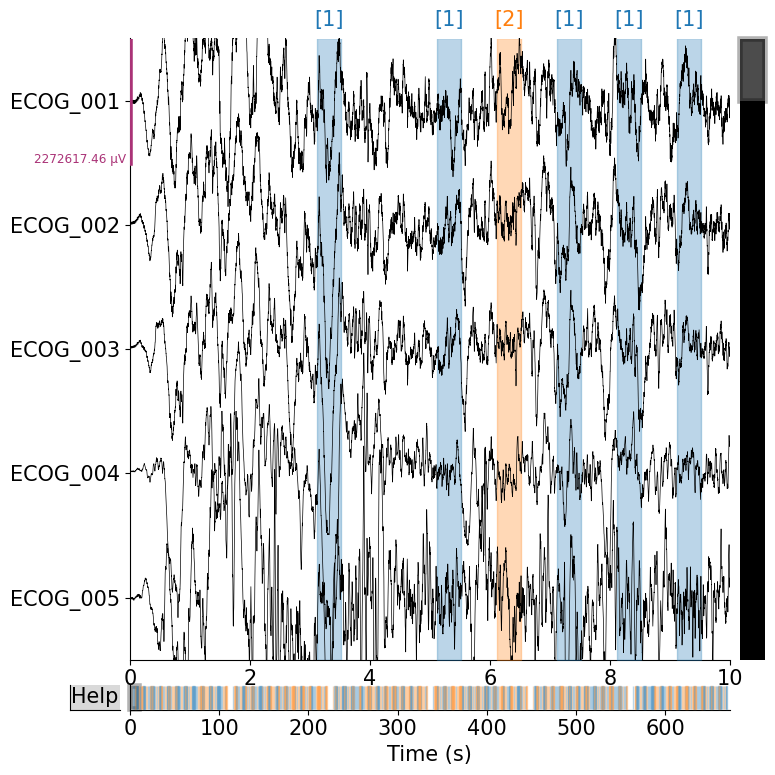

In [6]:
datamain.plot(n_channels=5, scalings="auto")

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\Administrator\AppData\Local\Temp\ipykernel_19308\4108630121.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
c:\ProgramData\anaconda3\Lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


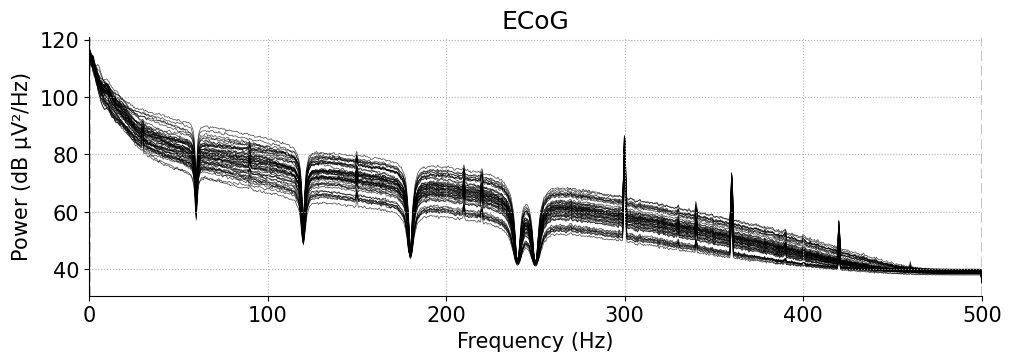

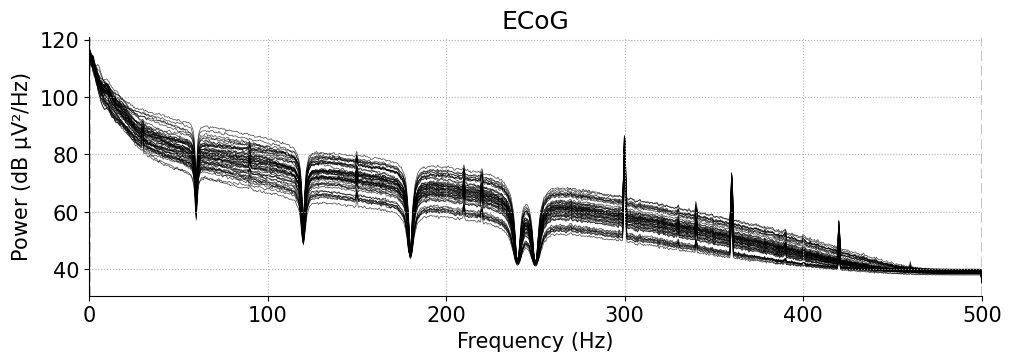

In [7]:
raw.compute_psd().plot()

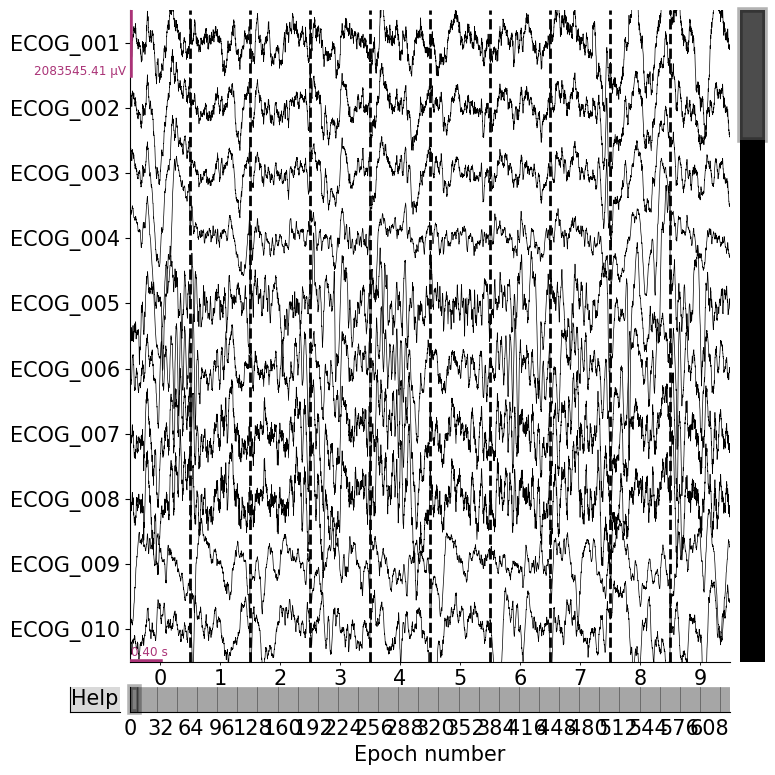

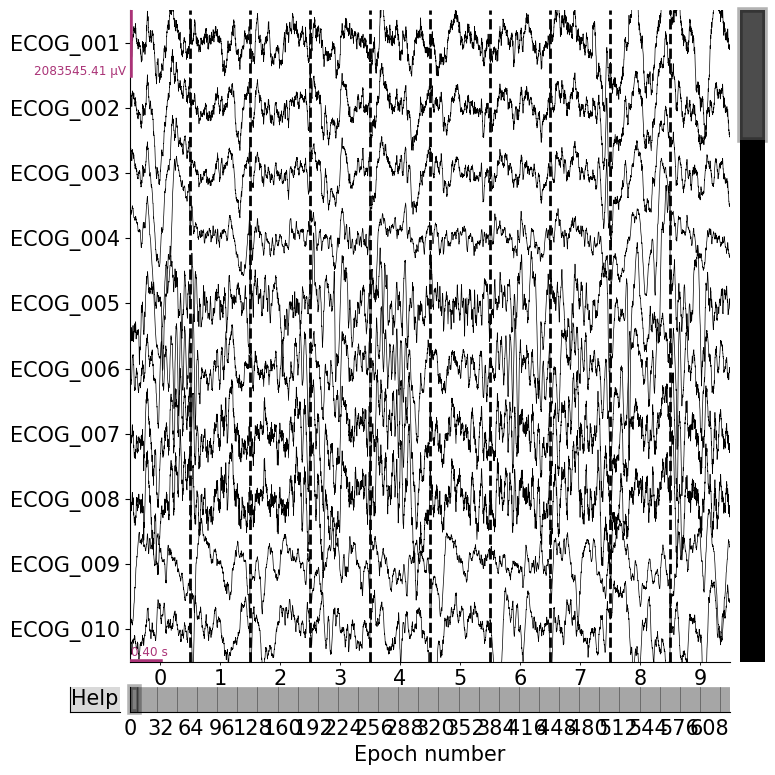

In [8]:
epochs.plot(n_channels=10,scalings="auto",n_epochs=10)

(array([1., 0., 0., 2., 5., 4., 4., 4., 4., 6., 4., 1., 2., 0., 5., 1., 1.,
        0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 8775390.625 ,  9063945.3125,  9352500.    ,  9641054.6875,
         9929609.375 , 10218164.0625, 10506718.75  , 10795273.4375,
        11083828.125 , 11372382.8125, 11660937.5   , 11949492.1875,
        12238046.875 , 12526601.5625, 12815156.25  , 13103710.9375,
        13392265.625 , 13680820.3125, 13969375.    , 14257929.6875,
        14546484.375 , 14835039.0625, 15123593.75  , 15412148.4375,
        15700703.125 , 15989257.8125, 16277812.5   , 16566367.1875,
        16854921.875 , 17143476.5625, 17432031.25  , 17720585.9375,
        18009140.625 , 18297695.3125, 18586250.    , 18874804.6875,
        19163359.375 , 19451914.0625, 19740468.75  , 20029023.4375,
        20317578.125 , 20606132.8125, 20894687.5   , 21183242.1875,
        21471796.875 , 217

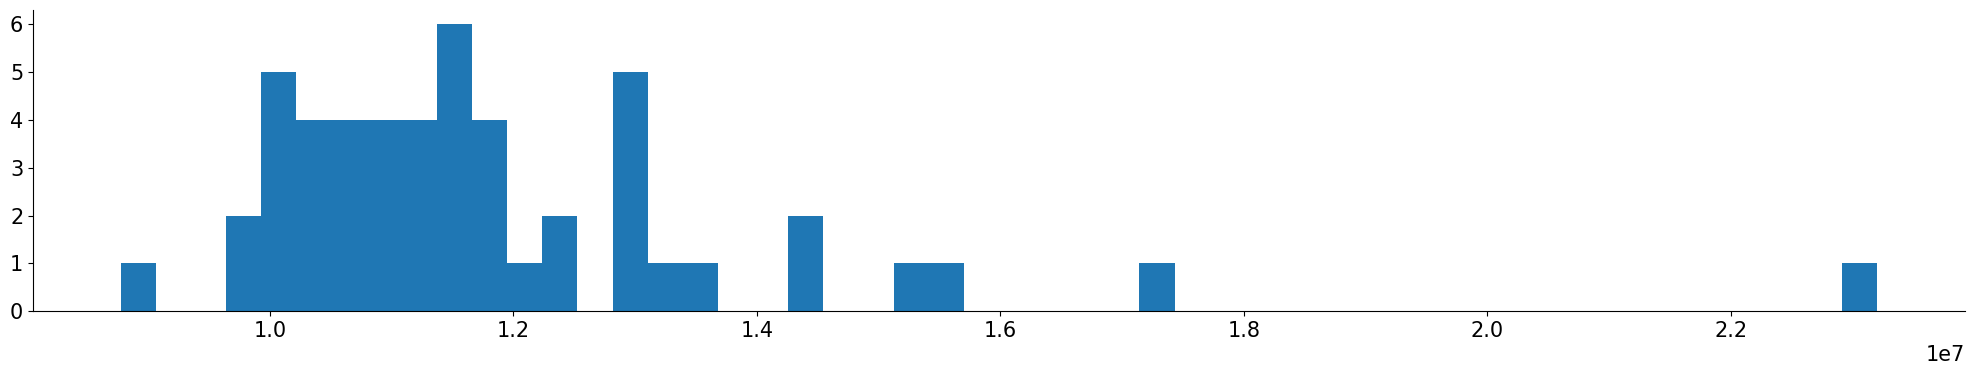

In [9]:
data = datamain.get_data(picks="ecog") * 1e6  # to μV
peak_to_peak = data.ptp(axis=1)  # peak-to-peak per channel
plt.hist(peak_to_peak, bins=50)


In [10]:
datamain.filter(l_freq=0.1, h_freq=290.0, fir_design='firwin')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 2.9e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 290.00 Hz
- Upper transition bandwidth: 72.50 Hz (-6 dB cutoff frequency: 326.25 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished


<RawArray | 50 x 672280 (672.3 s), ~256.5 MiB, data loaded>

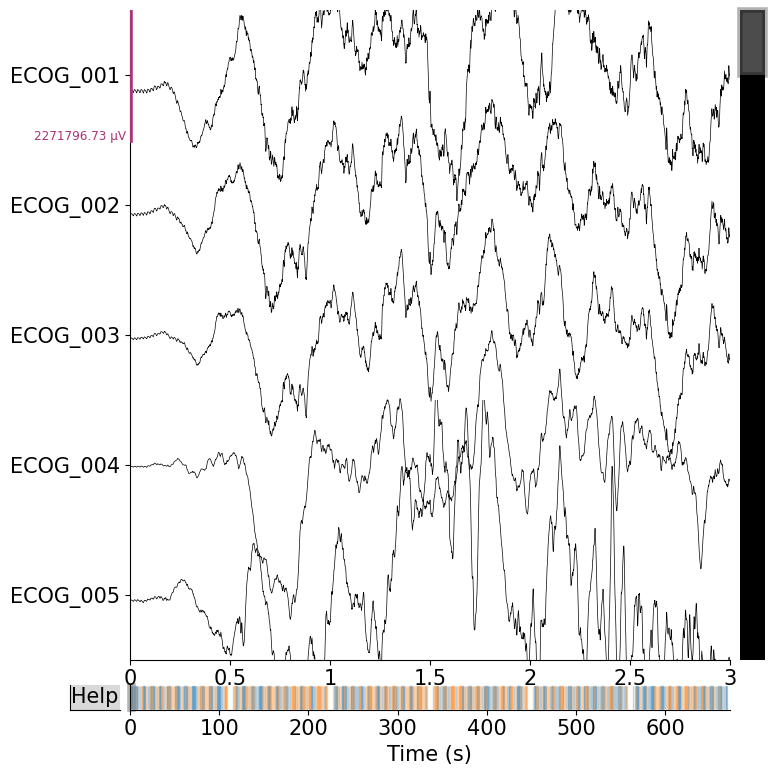

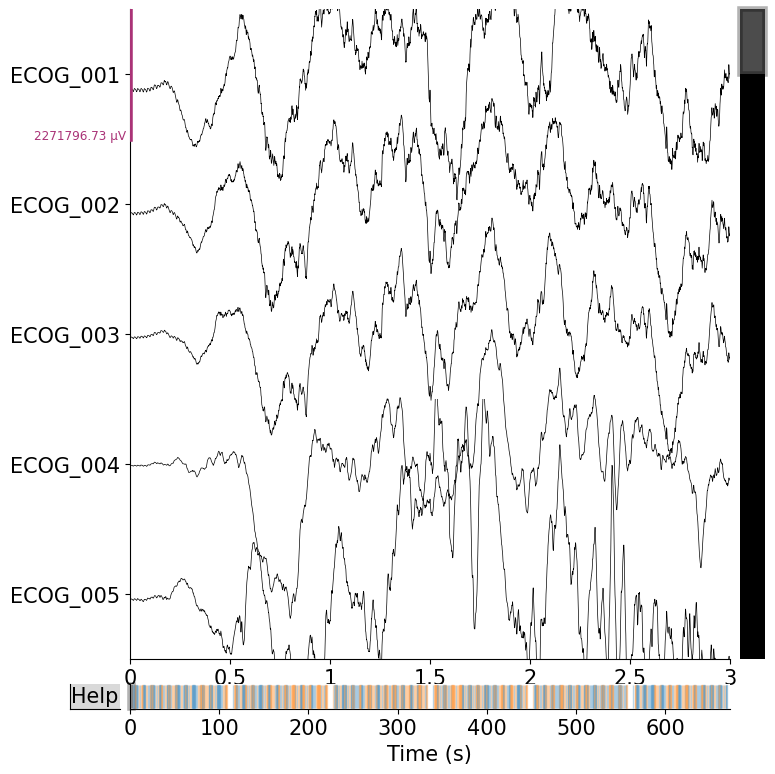

In [11]:
datamain.plot(
    n_channels=5,
    scalings="auto",  # Let MNE choose a reasonable scale
    duration=3,
)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import mne

def compute_snr(epochs: mne.Epochs, condition: str = None, tmin: float = 0.0, tmax: float = 0.5):
    """
    Compute per-channel signal-to-noise ratio (SNR) from evoked data.

    Parameters
    ----------
    epochs : mne.Epochs
        Epoched and baseline-corrected ECoG data.
    condition : str or None
        Epoch label (e.g., 'face'). If None, uses all epochs.
    tmin : float
        Start of time window (s) for computing SNR.
    tmax : float
        End of time window (s) for computing SNR.

    Returns
    -------
    snr : np.ndarray
        Array of SNR values (shape: n_channels).
    """

    if condition:
        epochs = epochs[condition]

    # Compute evoked response (average across trials)
    evoked = epochs.average()

    # Get data in the desired time window
    evoked_crop = evoked.copy().crop(tmin=tmin, tmax=tmax)
    data = evoked_crop.data  # shape: (n_channels, n_times)

    # Signal = mean absolute amplitude across time
    signal = np.abs(data).mean(axis=1)

    # Noise = standard deviation of residuals across trials
    residuals = epochs.get_data() - evoked.data[np.newaxis, :, :]
    residuals_crop = residuals[:, :, (epochs.time_as_index(tmin)[0]):(epochs.time_as_index(tmax)[0])]
    noise = residuals_crop.std(axis=(0, 2))  # std over trials and time

    snr = signal / noise

    # Plot (optional)
    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(len(snr)), snr)
    plt.xlabel('Channel Index')
    plt.ylabel('SNR')
    plt.title(f'Per-channel SNR ({condition if condition else "all conditions"})')
    plt.tight_layout()
    plt.show()

    return snr


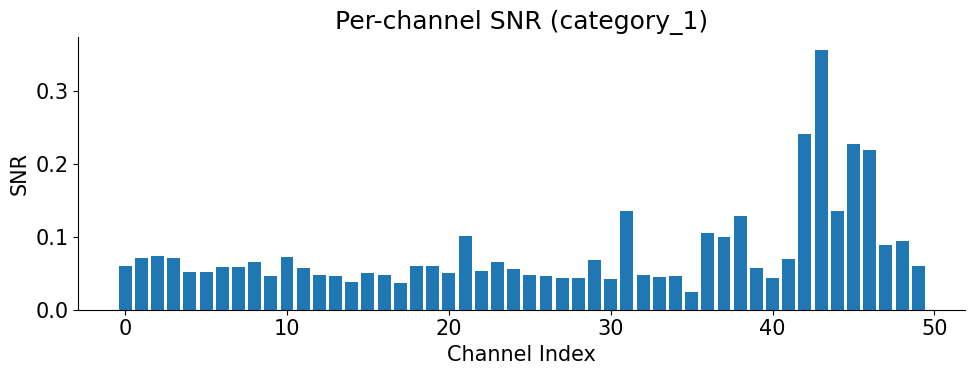

In [13]:
snr = compute_snr(epochs, condition='category_1', tmin=-0.2, tmax=0.6)


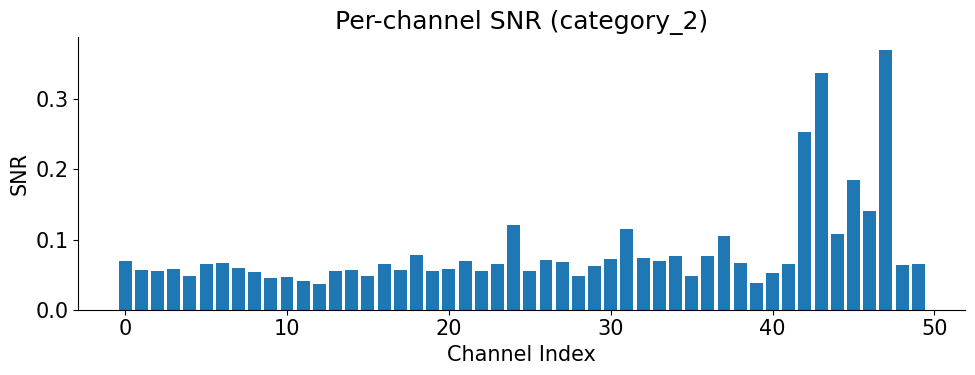

In [14]:
snr = compute_snr(epochs, condition='category_2', tmin=-0.2, tmax=0.6)


In [15]:
import numpy as np
import mne

def smooth_epochs(epochs, window_size_ms=20):
    """
    Apply temporal moving average smoothing to ECoG epochs.

    Parameters
    ----------
    epochs : mne.Epochs
        Epoched ECoG data.
    window_size_ms : float
        Size of the moving average window in milliseconds.

    Returns
    -------
    smoothed_epochs : mne.Epochs
        New Epochs object with temporally smoothed data.
    """
    smoothed_epochs = epochs.copy()
    data = smoothed_epochs.get_data()  # shape: (n_epochs, n_channels, n_times)

    sfreq = epochs.info['sfreq']  # sampling frequency (Hz)
    window_size_samples = int(window_size_ms / 1000 * sfreq)
    if window_size_samples < 1:
        raise ValueError("Window size too small for current sampling rate.")

    # Apply moving average along the time axis
    kernel = np.ones(window_size_samples) / window_size_samples
    data_smoothed = np.apply_along_axis(
        lambda m: np.convolve(m, kernel, mode='same'), axis=2, arr=data
    )

    smoothed_epochs._data = data_smoothed
    return smoothed_epochs


In [16]:
epochs_smooth = smooth_epochs(epochs, window_size_ms=20)

In [17]:
fwhm = 20  # in milliseconds
sigma_ms = fwhm / 2.355

from scipy.ndimage import gaussian_filter1d

def smooth_epochs_gaussian(epochs, fwhm_ms=20):
    """
    Apply Gaussian temporal smoothing to ECoG epochs using FWHM.

    Parameters
    ----------
    epochs : mne.Epochs
        Epoched ECoG data.
    fwhm_ms : float
        Full width at half maximum for the Gaussian kernel (in milliseconds).

    Returns
    -------
    smoothed_epochs : mne.Epochs
        New Epochs object with temporally smoothed data.
    """
    smoothed_epochs = epochs.copy()
    data = smoothed_epochs.get_data()  # (n_epochs, n_channels, n_times)

    sfreq = epochs.info['sfreq']
    sigma_samples = (fwhm_ms / 2.355) * (sfreq / 1000)  # convert FWHM to samples

    # Apply Gaussian smoothing along the time axis
    data_smoothed = gaussian_filter1d(data, sigma=sigma_samples, axis=2, mode='nearest')
    smoothed_epochs._data = data_smoothed
    return smoothed_epochs


In [18]:
epochs_smooth = smooth_epochs_gaussian(epochs, fwhm_ms=20)


In [19]:
evoked_face = epochs['category_2'].average()
evoked_house = epochs['category_1'].average()


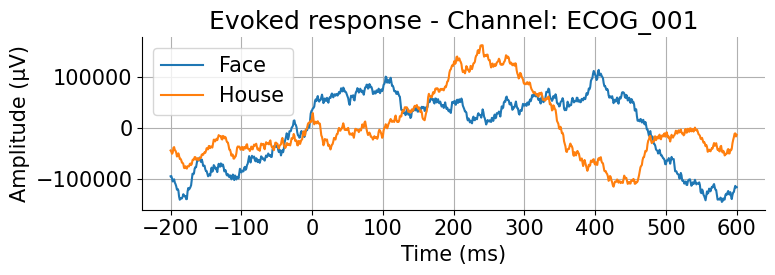

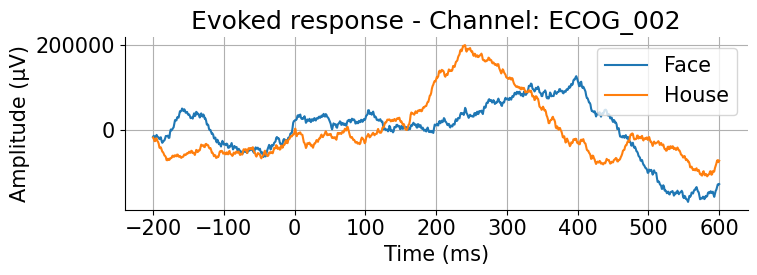

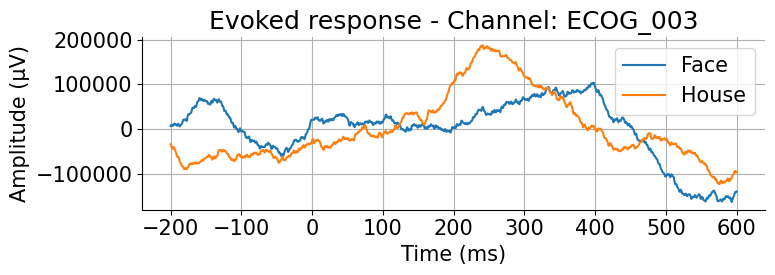

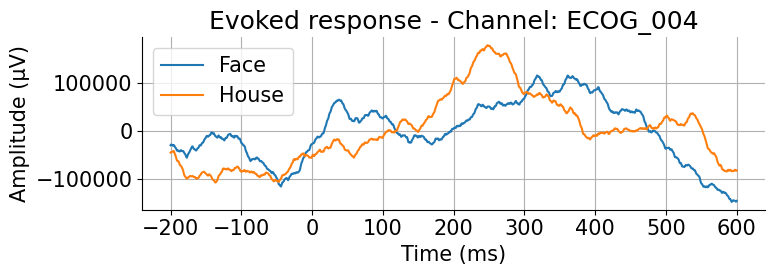

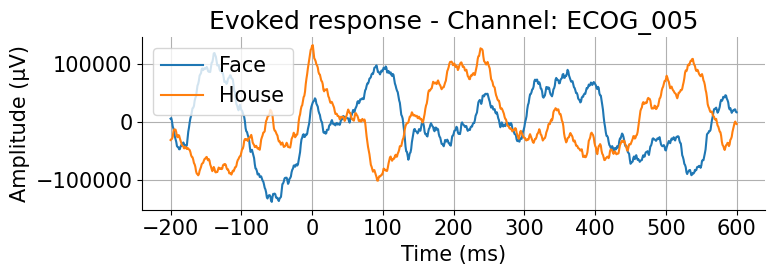

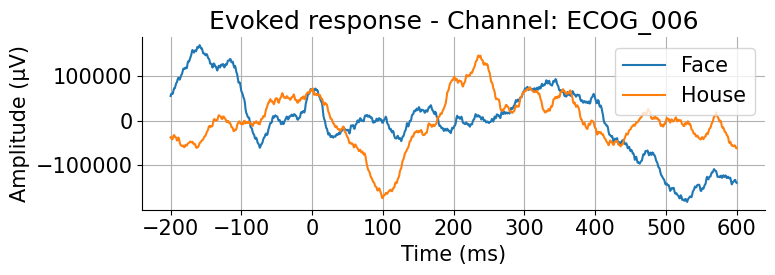

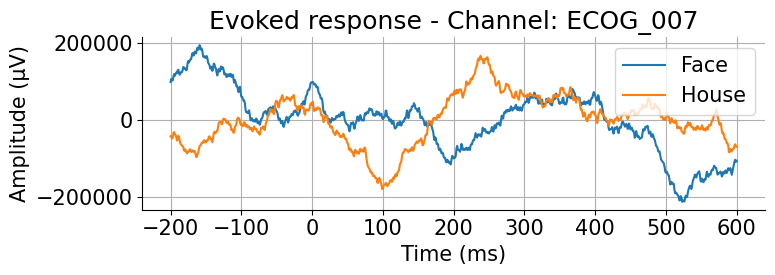

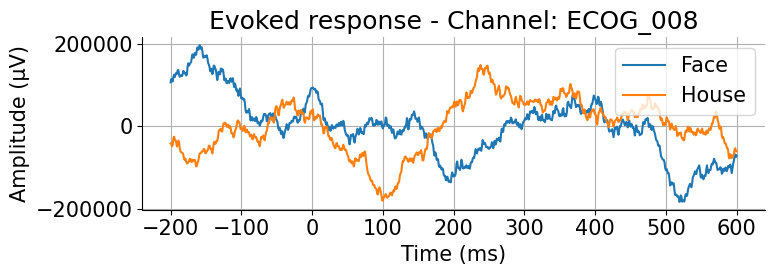

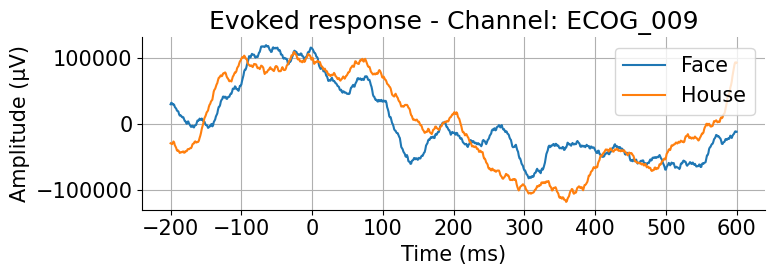

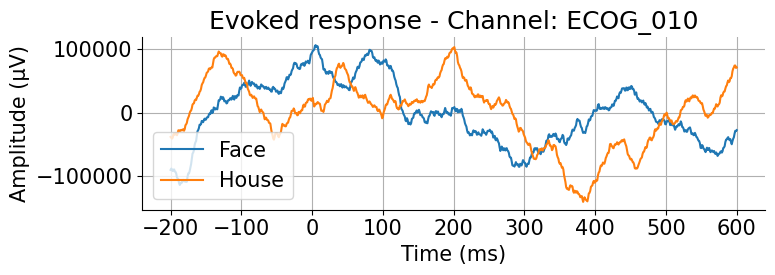

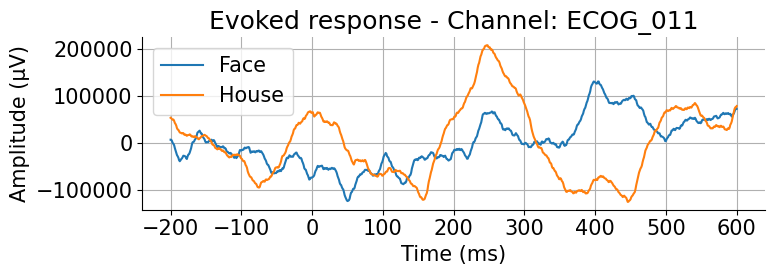

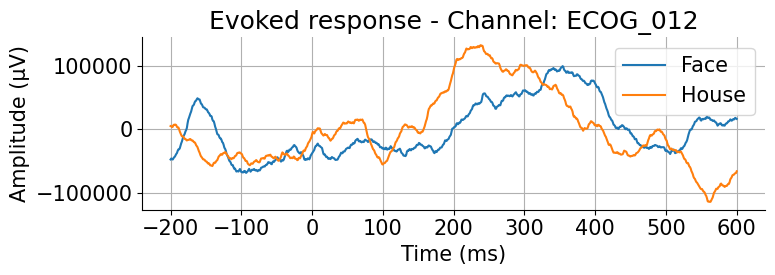

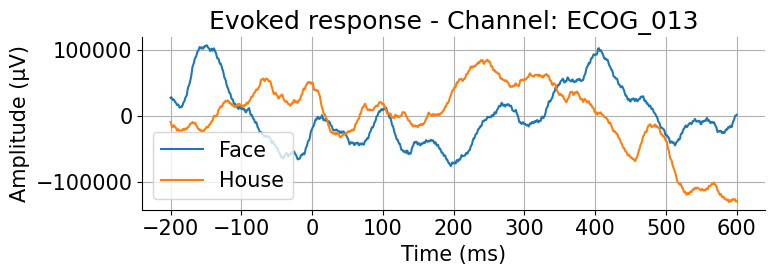

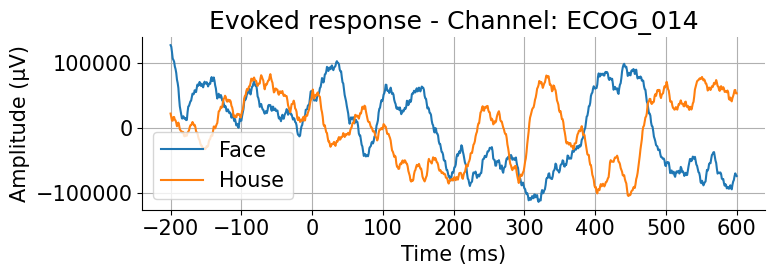

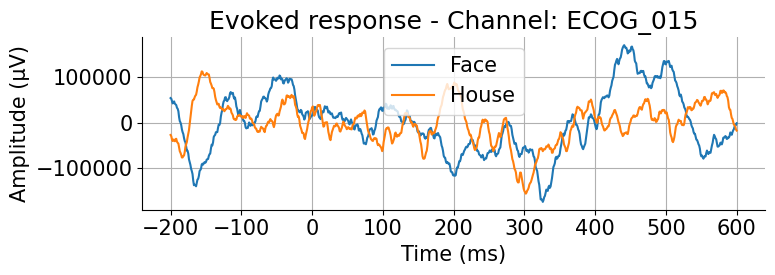

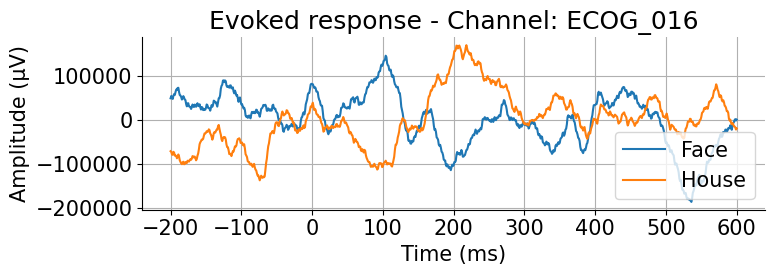

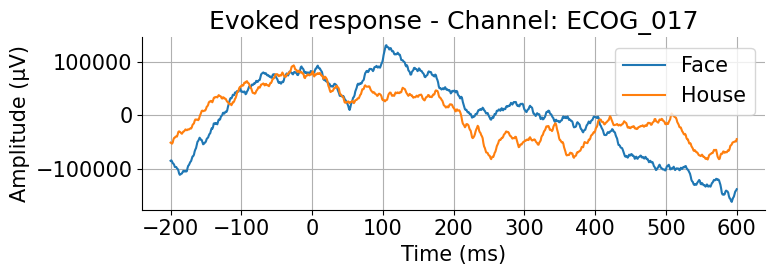

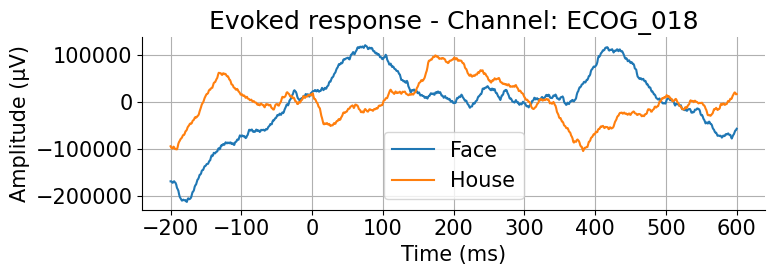

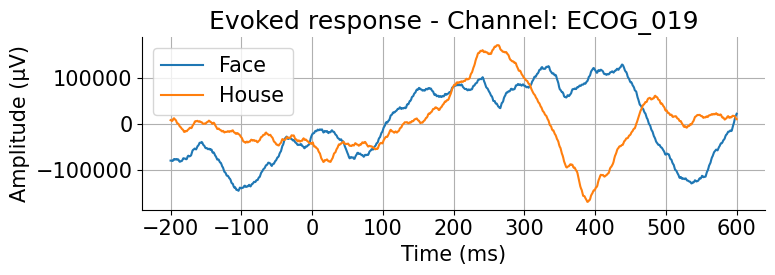

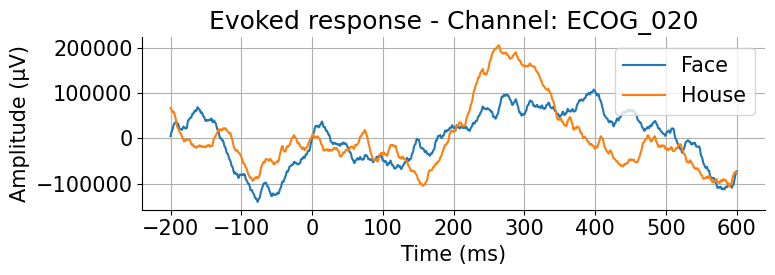

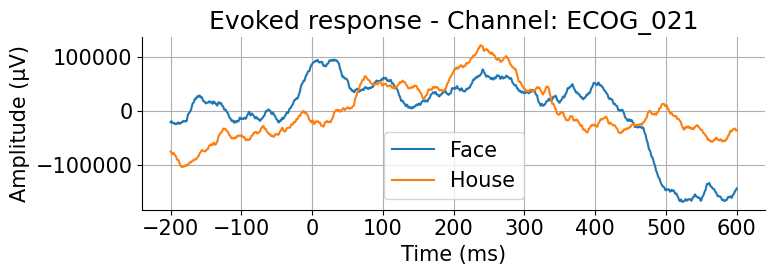

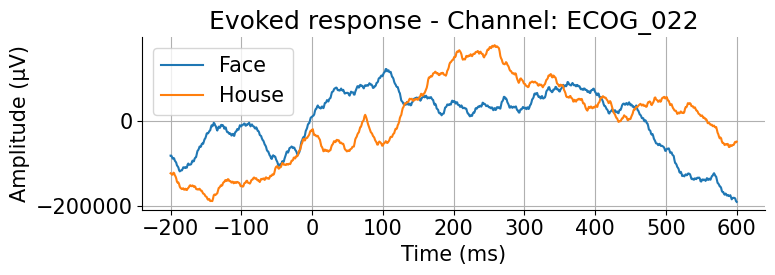

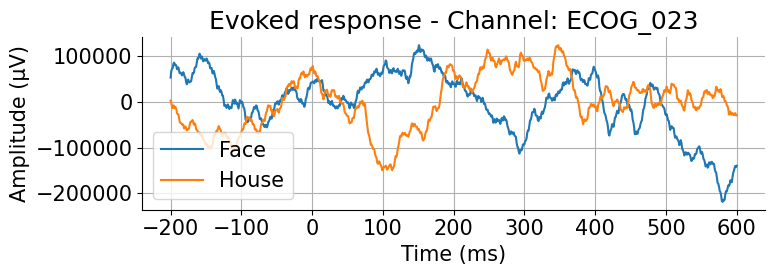

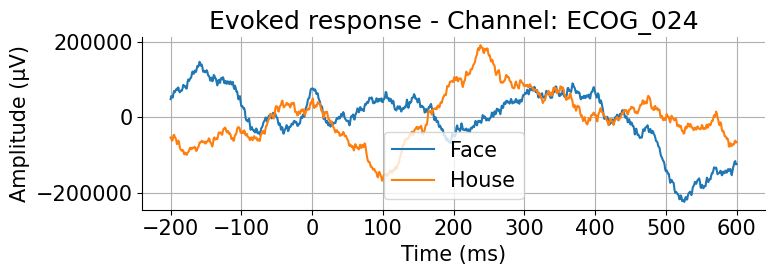

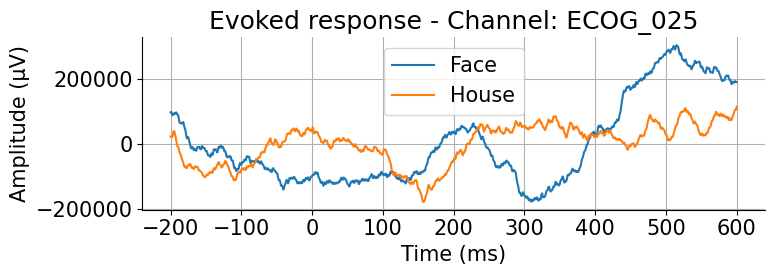

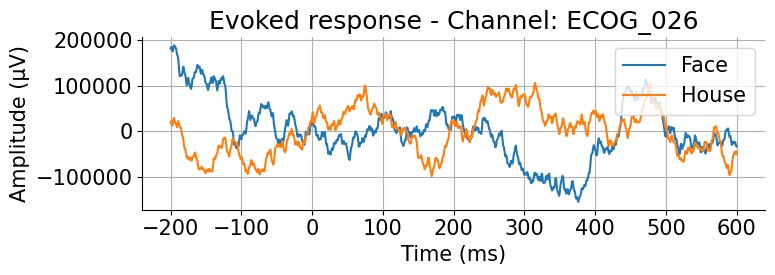

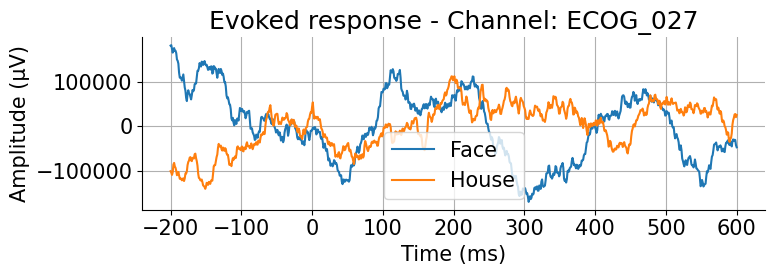

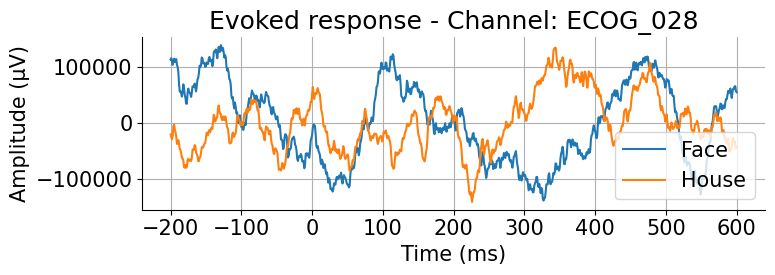

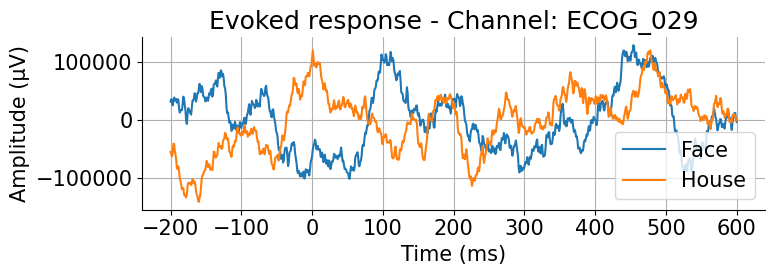

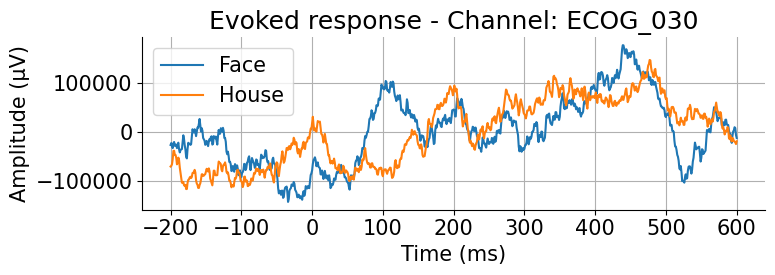

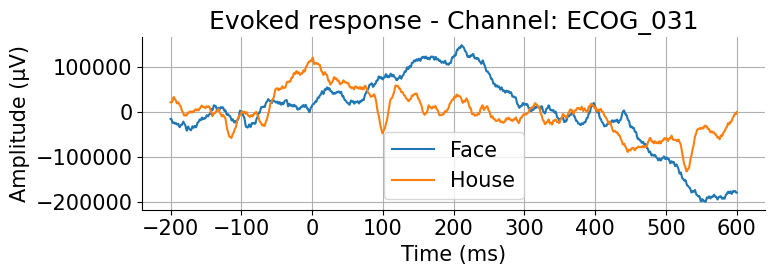

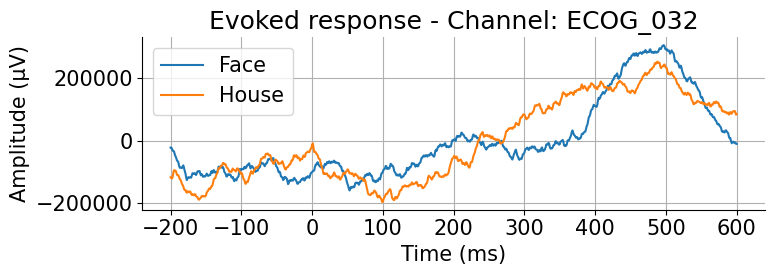

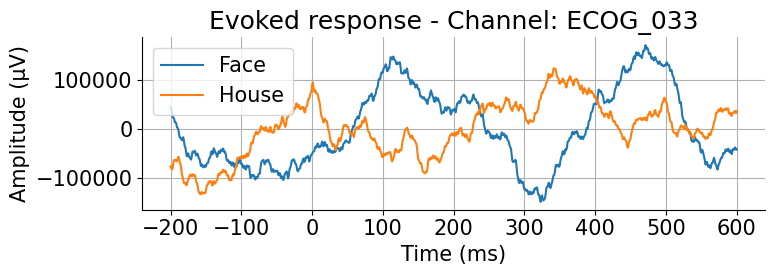

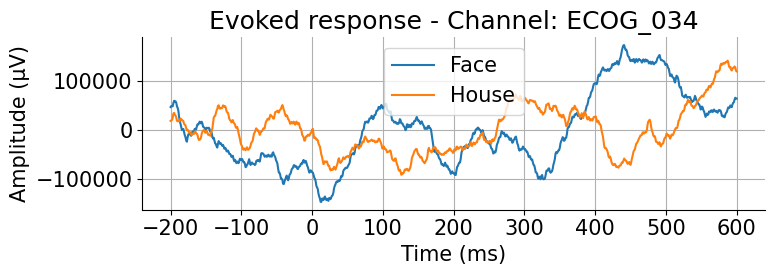

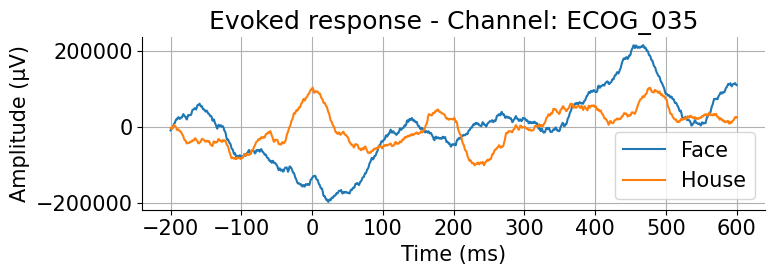

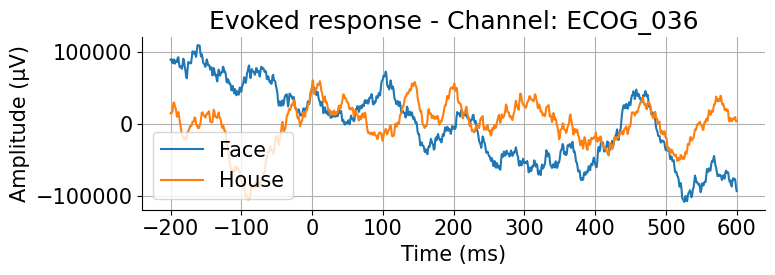

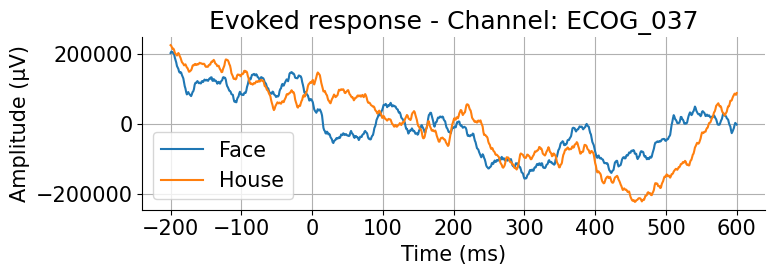

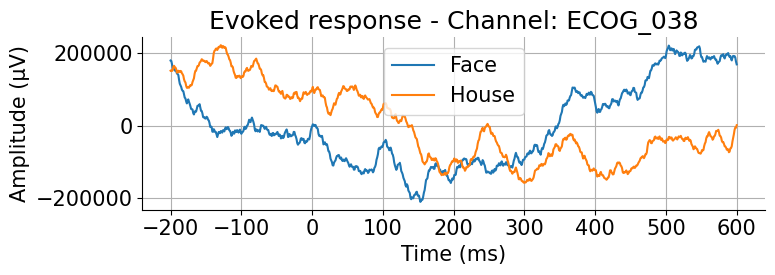

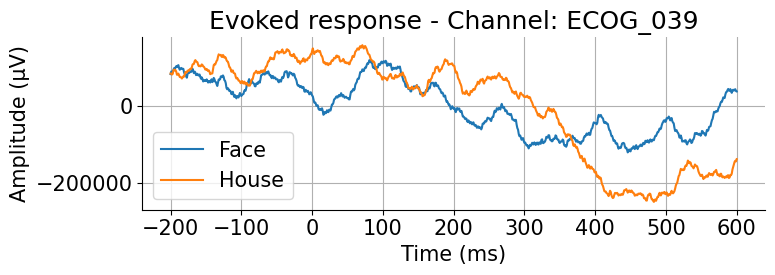

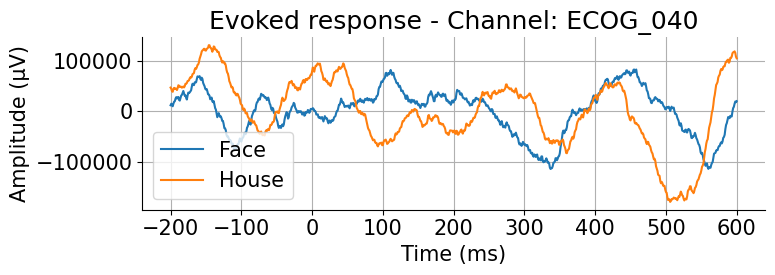

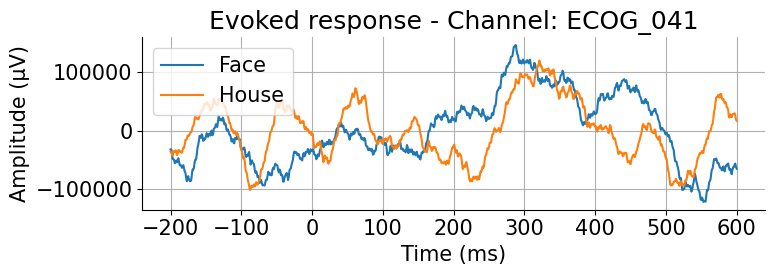

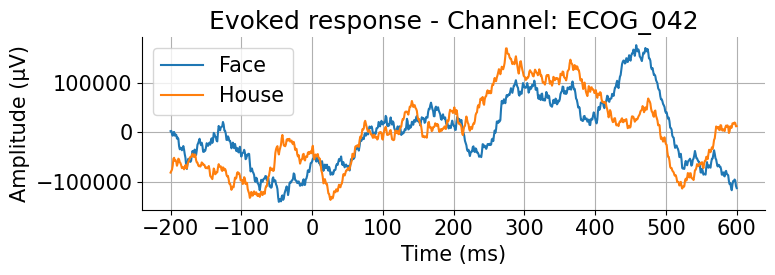

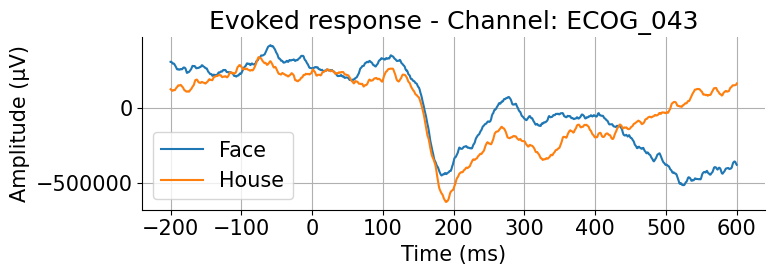

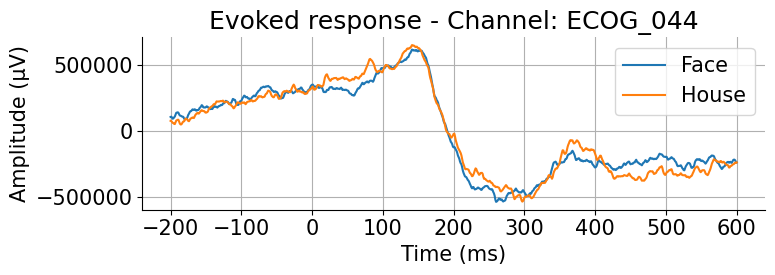

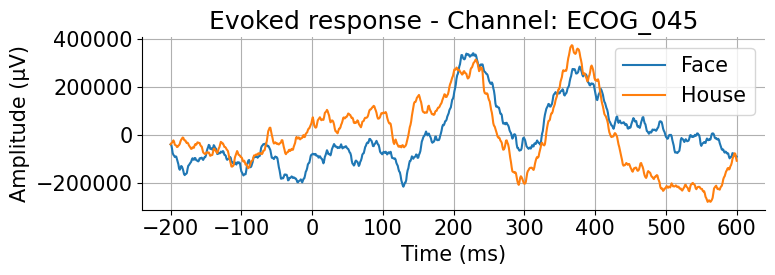

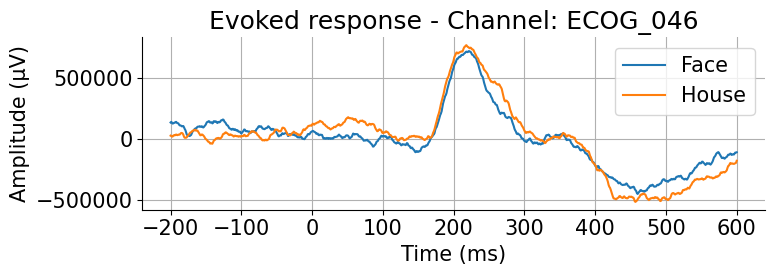

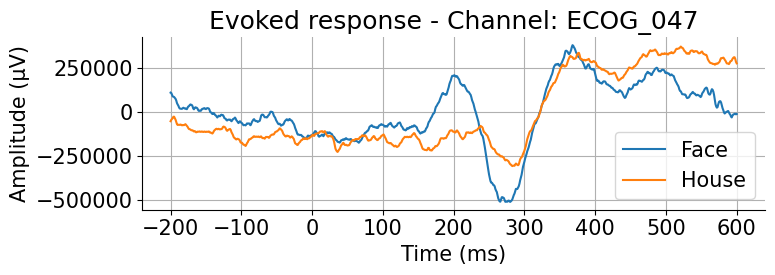

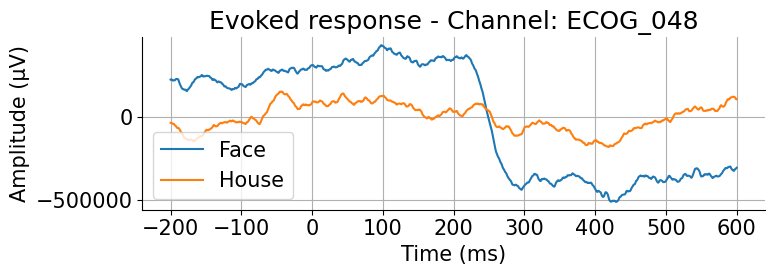

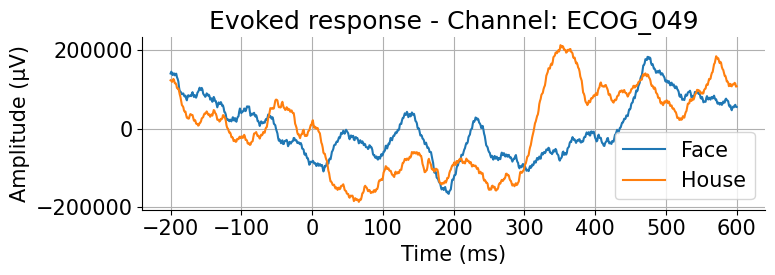

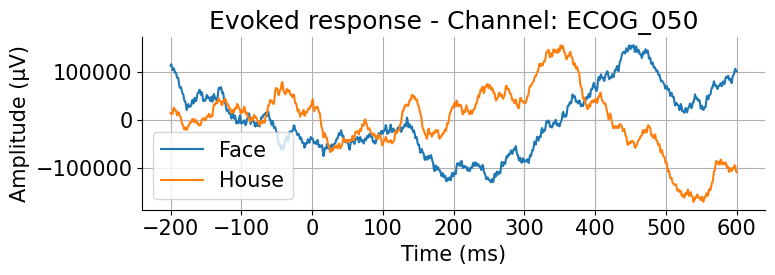

In [20]:
for ch_idx, ch_name in enumerate(evoked_face.ch_names):
    plt.figure(figsize=(8, 3))
    plt.plot(evoked_face.times * 1000, evoked_face.data[ch_idx] * 1e6, label='Face')
    plt.plot(evoked_house.times * 1000, evoked_house.data[ch_idx] * 1e6, label='House')
    plt.title(f"Evoked response - Channel: {ch_name}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (μV)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
evoked_faces = epochs_smooth['category_2'].average()
evoked_houses = epochs_smooth['category_1'].average()

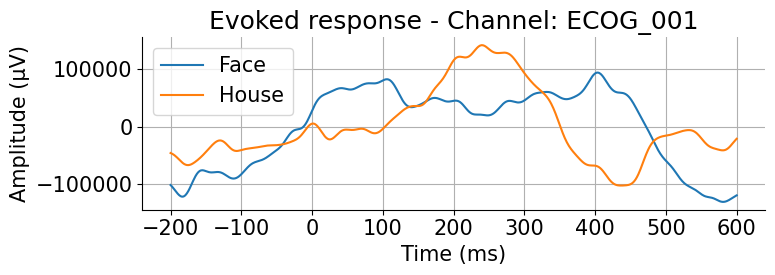

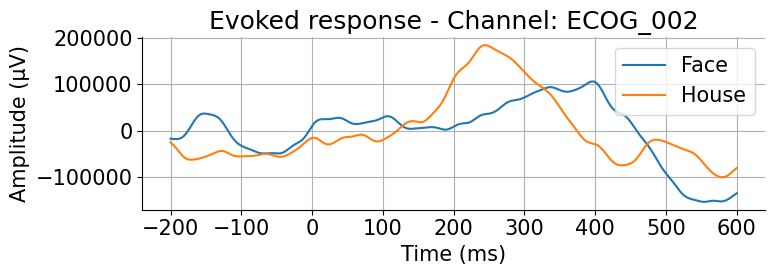

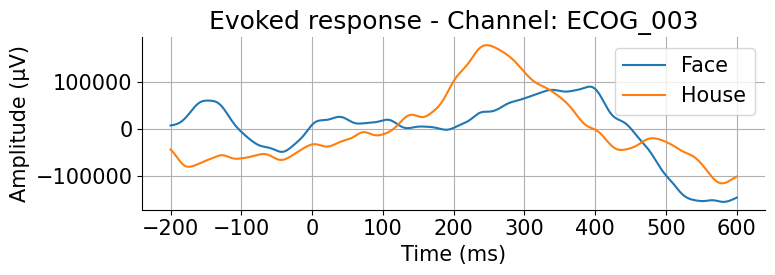

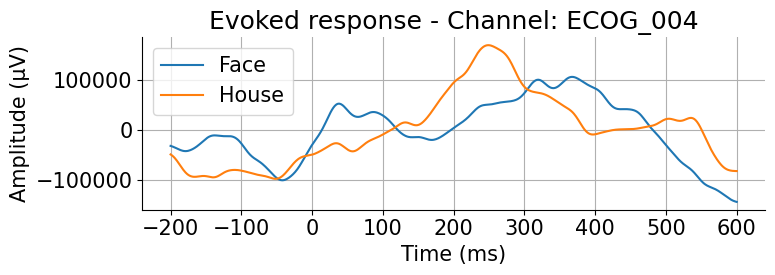

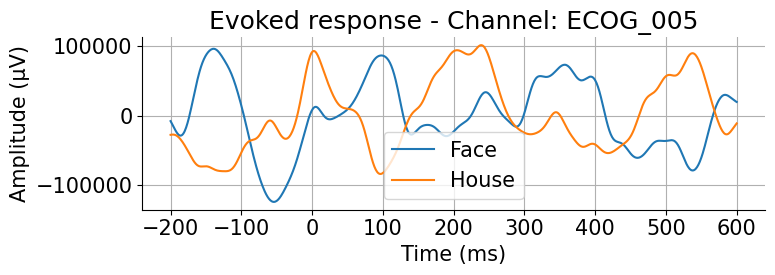

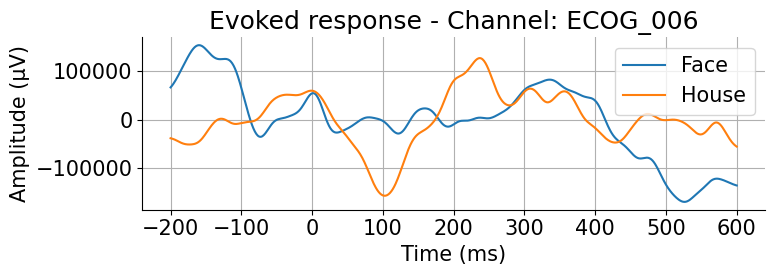

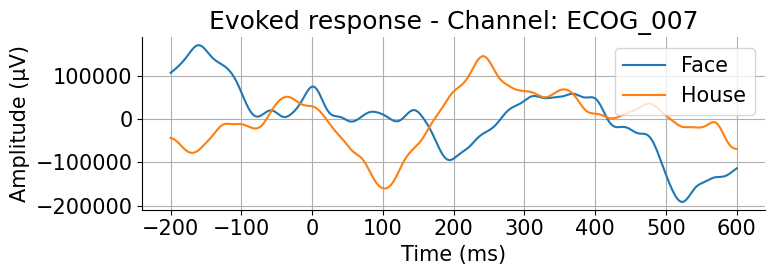

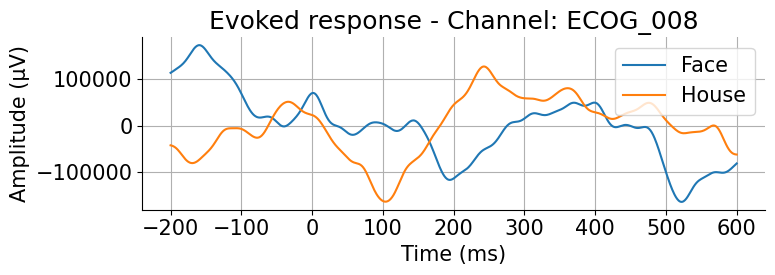

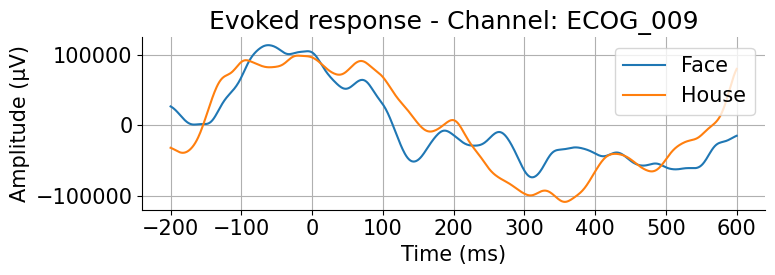

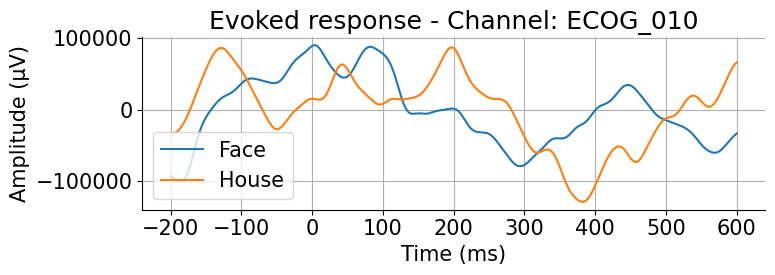

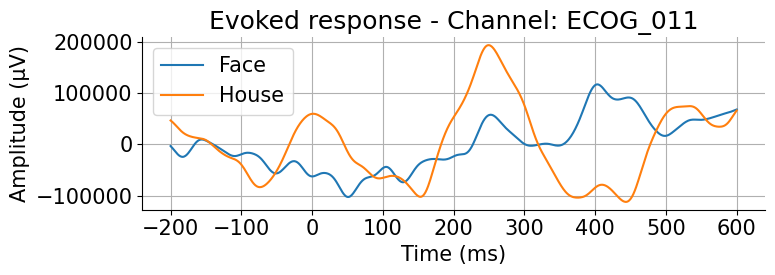

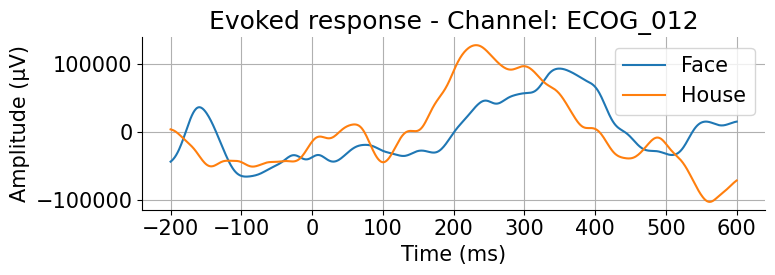

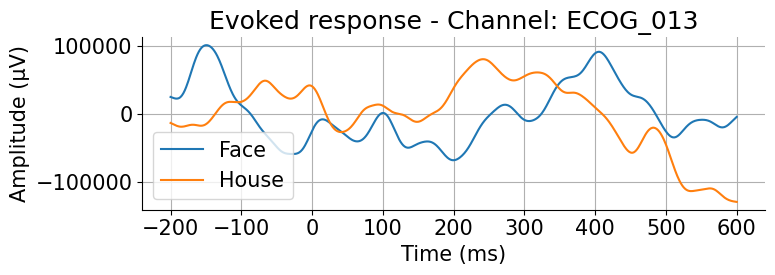

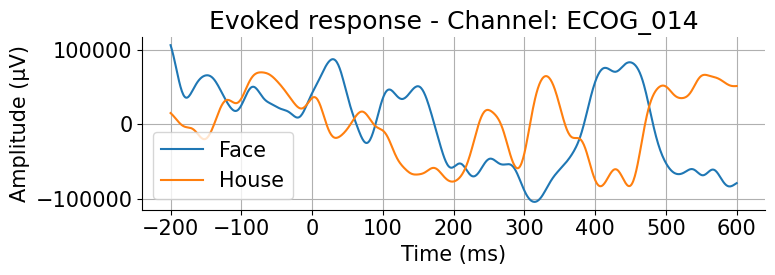

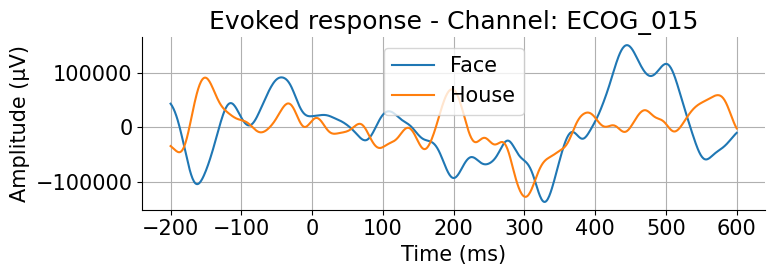

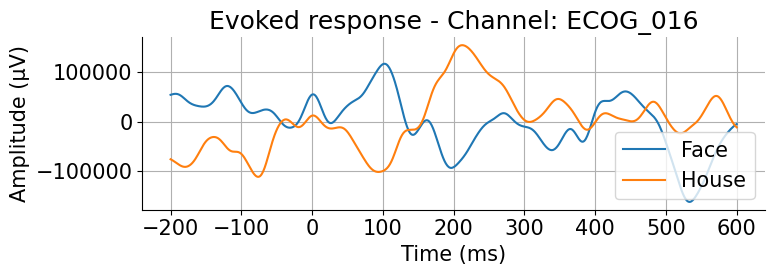

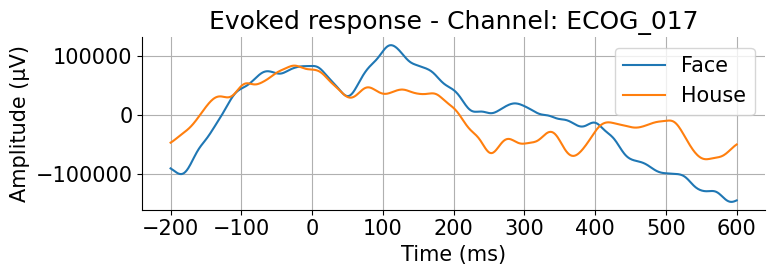

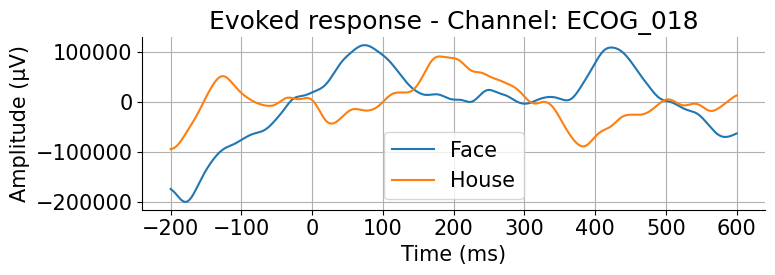

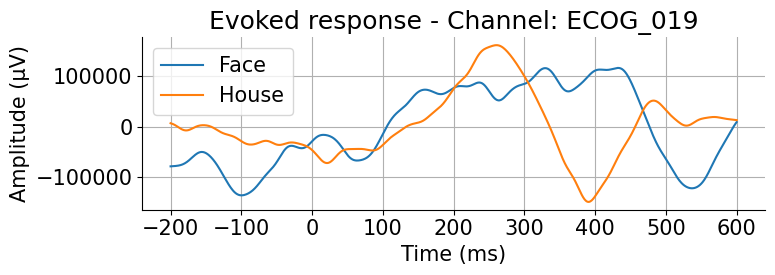

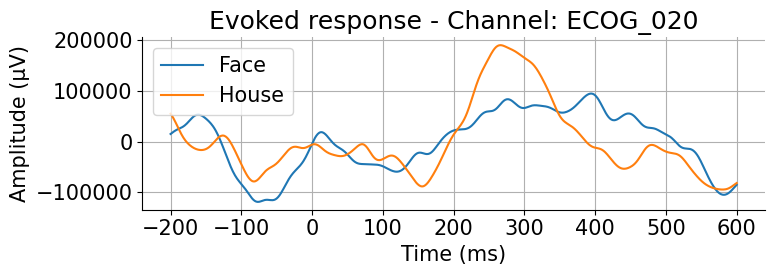

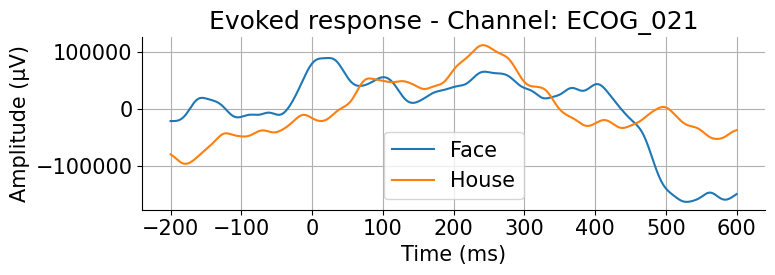

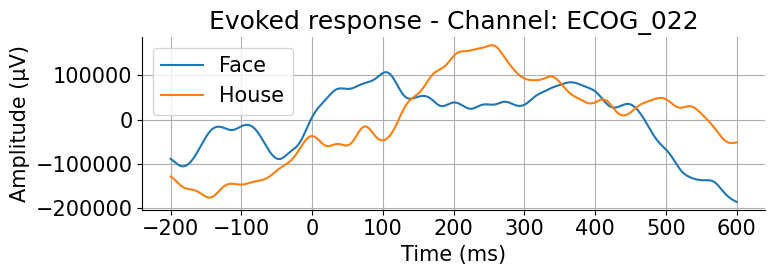

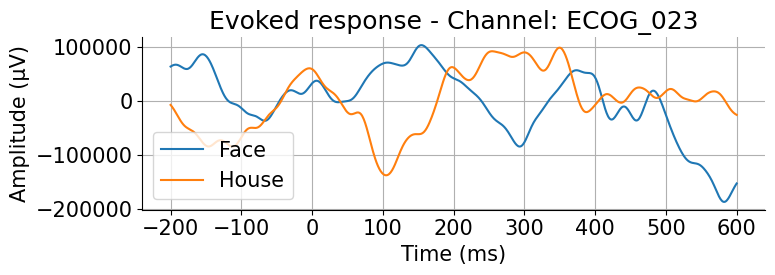

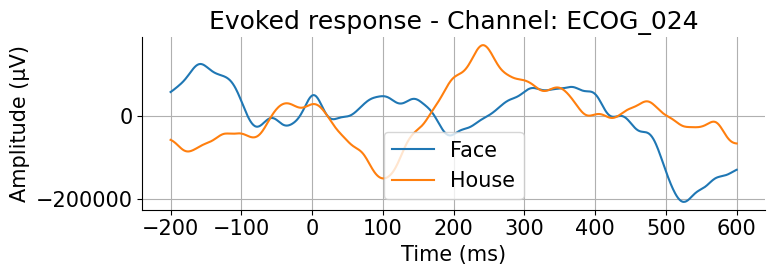

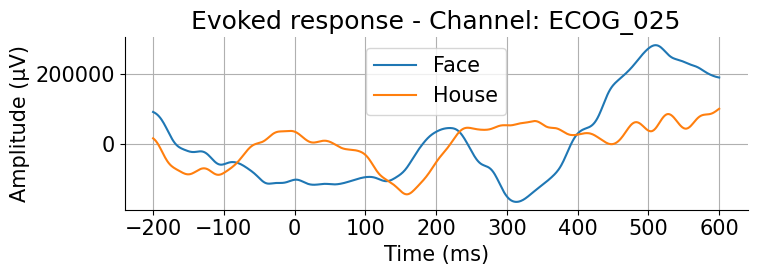

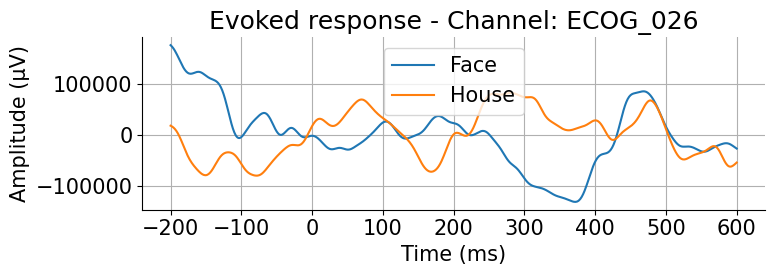

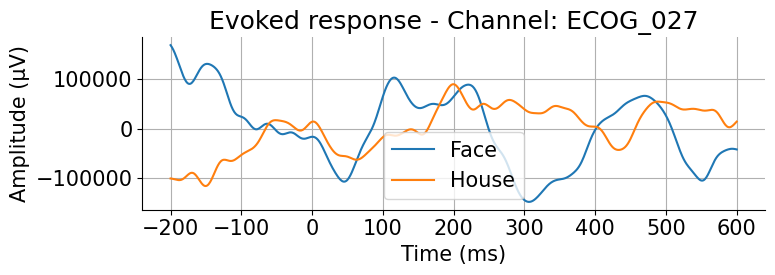

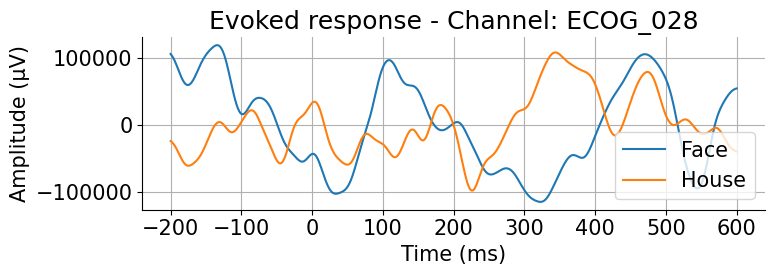

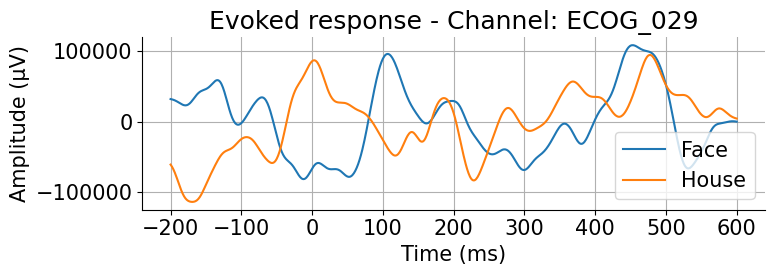

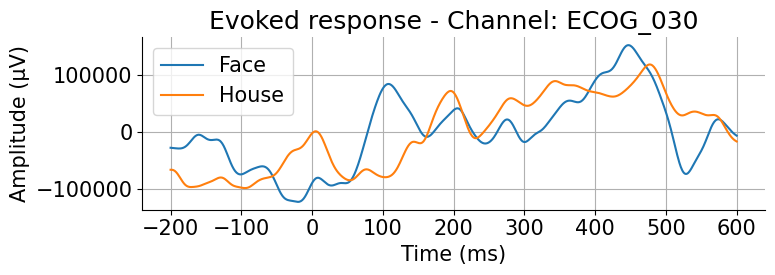

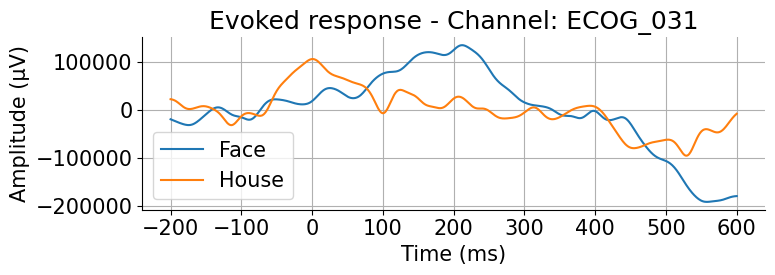

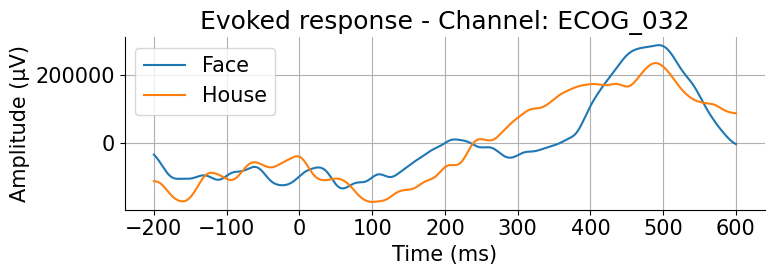

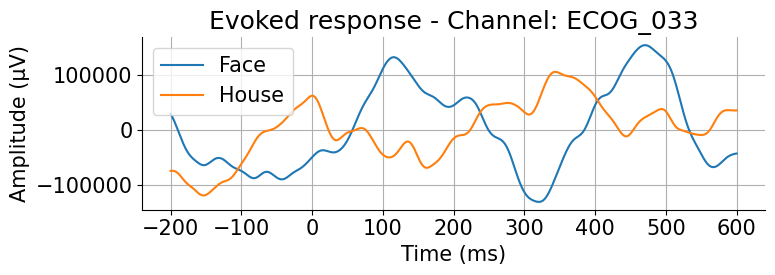

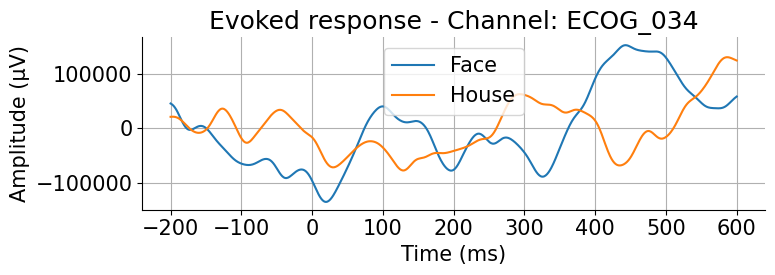

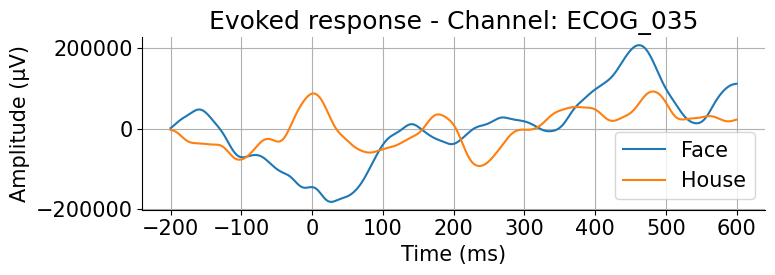

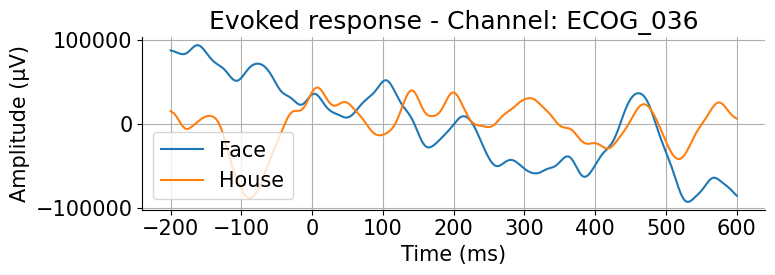

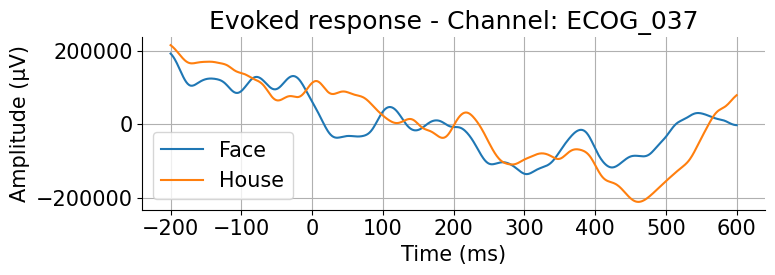

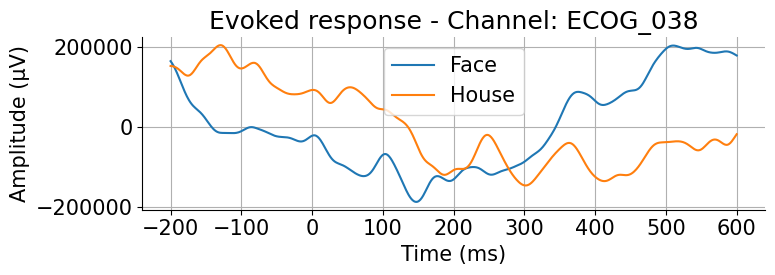

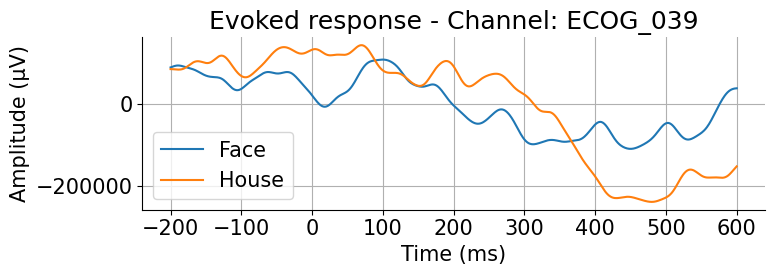

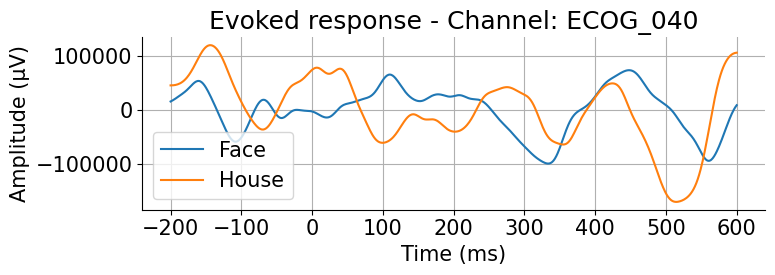

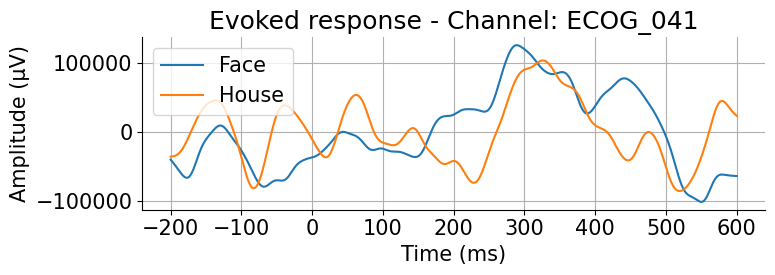

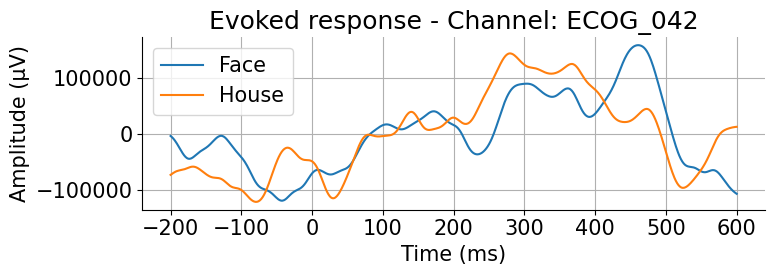

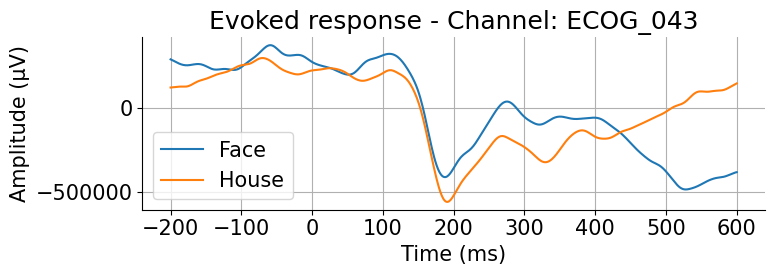

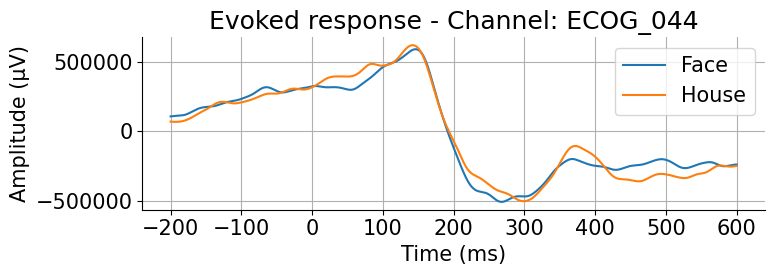

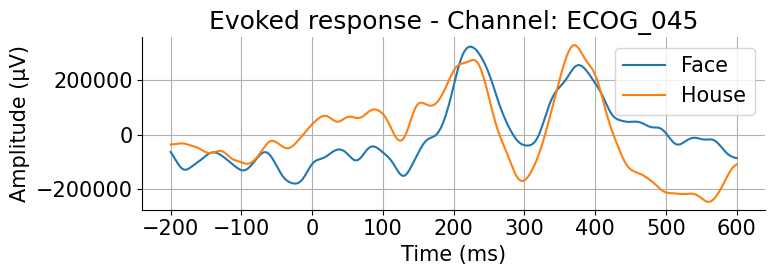

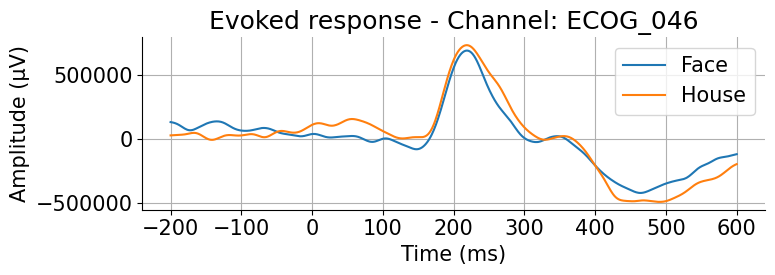

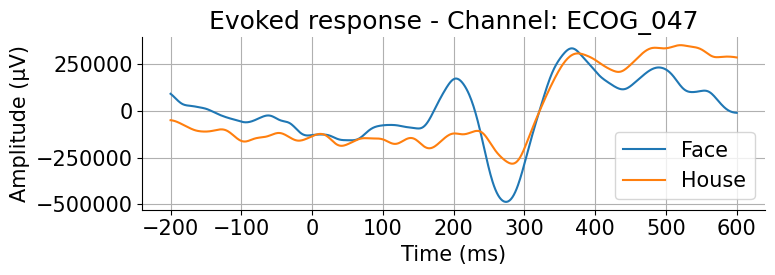

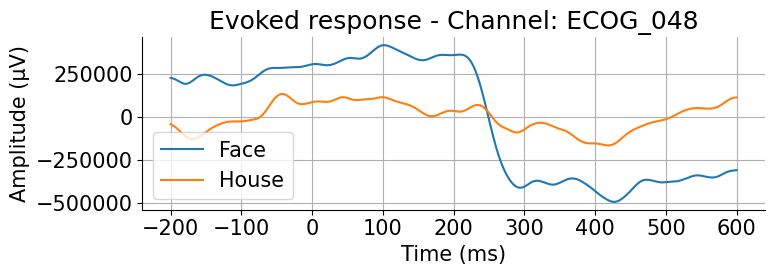

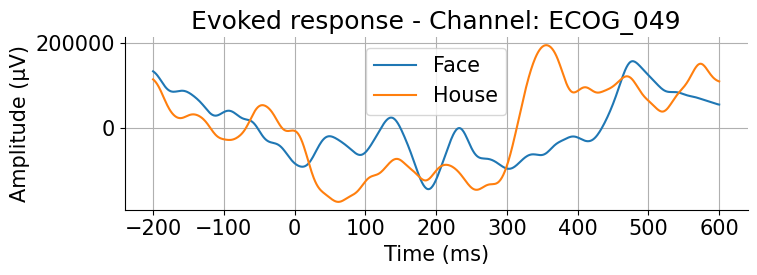

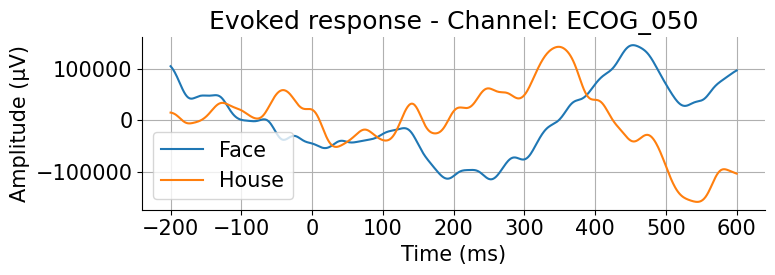

In [22]:
for ch_idx, ch_name in enumerate(evoked_faces.ch_names):
    plt.figure(figsize=(8, 3))
    plt.plot(evoked_faces.times * 1000, evoked_faces.data[ch_idx] * 1e6, label='Face')
    plt.plot(evoked_houses.times * 1000, evoked_houses.data[ch_idx] * 1e6, label='House')
    plt.title(f"Evoked response - Channel: {ch_name}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (μV)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Great — let’s walk through how to perform Multivariate Pattern Analysis (MVPA) using the PyMVPA package on ECoG data.

We'll assume:

You already have epochs in MNE format (epochs['face'], epochs['house'], etc.).

You want to classify between two conditions (e.g. 'face' vs 'house').

You want to apply a time-resolved classification (i.e. sliding across time points).

Sampling rate is 1000 Hz.

In [23]:
import mvpa

def prepare_mvpa_dataset(epochs, cond1='face', cond2='house'):
    # Select epochs and concatenate
    epochs_combined = mne.concatenate_epochs([epochs[cond1], epochs[cond2]])
    X = epochs_combined.get_data()  # shape: (n_trials, n_channels, n_times)
    
    n_trials, n_channels, n_times = X.shape
    
    # Labels: 0 for cond1, 1 for cond2
    y = np.array([0] * len(epochs[cond1]) + [1] * len(epochs[cond2]))

    # Reshape for PyMVPA: (samples, features)
    # We'll treat each timepoint as a separate feature set across channels
    X_mvpa = X.transpose(0, 2, 1).reshape(n_trials * n_times, n_channels)

    # Sample attributes
    chunks = np.repeat(np.arange(n_trials), n_times)
    targets = np.repeat(y, n_times)
    timepoints = np.tile(np.arange(n_times), n_trials)

    # Create PyMVPA Dataset
    ds = Dataset(X_mvpa)
    ds.sa['targets'] = targets
    ds.sa['chunks'] = chunks
    ds.sa['timepoints'] = timepoints

    return ds, n_times


def run_mvpa_time_resolved(ds, n_times):
    clf = LinearCSVMC()  # SVM classifier

    # We'll do classification separately at each timepoint
    acc_per_time = []

    for t in range(n_times):
        # Select all samples at this timepoint
        ds_t = ds[ds.sa.timepoints == t]

        # 5-fold cross-validation
        cv = CrossValidation(clf, NFoldPartitioner(), errorfx=mean_match_accuracy)
        acc = np.mean(cv(ds_t))
        acc_per_time.append(acc)

    return np.array(acc_per_time)


ModuleNotFoundError: No module named 'mvpa'

In [ ]:
# Prepare dataset
ds, n_times = prepare_mvpa_dataset(epochs, cond1='face', cond2='house')

# Run decoding
acc_timecourse = run_mvpa_time_resolved(ds, n_times)

# Plot
import matplotlib.pyplot as plt
times = epochs.times * 1000  # ms

plt.figure(figsize=(8, 4))
plt.plot(times, acc_timecourse)
plt.axhline(0.5, color='gray', linestyle='--', label='Chance')
plt.xlabel("Time (ms)")
plt.ylabel("Accuracy")
plt.title("Time-resolved decoding (face vs house)")
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from mne.decoding import SlidingEstimator
# Extract data and labels
X = epochs.get_data()  # shape: (n_trials, n_channels, n_times)
y = epochs.events[:, 2]  # event IDs corresponding to noise levels
print(epochs.event_id)  # e.g., {'noise_0': 1, 'noise_0.2': 2, ...}
#If needed, remap event IDs to class labels:

# Example: {'noise_0': 1, 'noise_0.2': 2, 'noise_0.4': 3, 'noise_0.6': 4}
noise_map = {1: 0, 2: 1, 3: 2, 4: 3}
y = np.array([noise_map[label] for label in y])
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='lbfgs',  # better for multinomial
        multi_class='multinomial',
        max_iter=1000
    )
)

time_clf = SlidingEstimator(clf, scoring='accuracy', n_jobs=-1, verbose=True)
scores = cross_val_score(time_clf, X, y, cv=5)  # returns accuracy per time point
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(time_clf, X, y, cv=5)
times = epochs.times * 1000  # ms

plt.figure(figsize=(8, 4))
plt.plot(times, scores, label='Multi-class Accuracy')
plt.axhline(1.0 / len(np.unique(y)), color='gray', linestyle='--', label='Chance')
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy')
plt.title('Time-resolved Decoding (Noise Level Classification)')
plt.legend()
plt.tight_layout()
plt.show()


{'category_1': 1, 'category_2': 2}


  0%|          | Fitting SlidingEstimator : 0/801 [00:00<?,       ?it/s]

ValueError: scoring must return a number, got [0.56349206 0.57142857 0.53968254 0.54761905 0.51587302 0.50793651
 0.5        0.50793651 0.52380952 0.5        0.5        0.49206349
 0.5        0.50793651 0.50793651 0.5        0.5        0.48412698
 0.46825397 0.47619048 0.48412698 0.5        0.46825397 0.46825397
 0.46031746 0.44444444 0.46825397 0.48412698 0.5        0.53968254
 0.53968254 0.51587302 0.53174603 0.54761905 0.53968254 0.53968254
 0.53174603 0.52380952 0.50793651 0.52380952 0.54761905 0.55555556
 0.55555556 0.53968254 0.53174603 0.52380952 0.53174603 0.53174603
 0.52380952 0.5        0.51587302 0.51587302 0.50793651 0.5
 0.49206349 0.48412698 0.48412698 0.5        0.52380952 0.53968254
 0.53968254 0.53174603 0.53968254 0.55555556 0.52380952 0.53174603
 0.51587302 0.53174603 0.55555556 0.55555556 0.53968254 0.53968254
 0.53968254 0.53174603 0.53968254 0.54761905 0.53968254 0.55555556
 0.57142857 0.56349206 0.55555556 0.55555556 0.55555556 0.56349206
 0.53174603 0.51587302 0.50793651 0.53174603 0.55555556 0.57142857
 0.53968254 0.55555556 0.57142857 0.54761905 0.53174603 0.5
 0.51587302 0.51587302 0.51587302 0.52380952 0.52380952 0.53968254
 0.55555556 0.53968254 0.52380952 0.5        0.51587302 0.51587302
 0.50793651 0.51587302 0.51587302 0.53174603 0.50793651 0.5
 0.51587302 0.51587302 0.52380952 0.55555556 0.57142857 0.57142857
 0.57936508 0.57936508 0.5952381  0.57936508 0.5952381  0.58730159
 0.57936508 0.57142857 0.6031746  0.61904762 0.58730159 0.58730159
 0.58730159 0.6031746  0.57142857 0.53174603 0.55555556 0.57142857
 0.57142857 0.5952381  0.5952381  0.57142857 0.56349206 0.55555556
 0.53174603 0.52380952 0.52380952 0.50793651 0.49206349 0.53968254
 0.52380952 0.53174603 0.54761905 0.57142857 0.57142857 0.56349206
 0.57142857 0.56349206 0.57142857 0.55555556 0.53174603 0.51587302
 0.51587302 0.50793651 0.5        0.5        0.5        0.49206349
 0.5        0.51587302 0.52380952 0.54761905 0.57142857 0.55555556
 0.54761905 0.51587302 0.53968254 0.53968254 0.5952381  0.6031746
 0.58730159 0.58730159 0.56349206 0.55555556 0.55555556 0.56349206
 0.55555556 0.55555556 0.54761905 0.53174603 0.53174603 0.50793651
 0.53968254 0.54761905 0.53968254 0.53174603 0.56349206 0.56349206
 0.55555556 0.55555556 0.56349206 0.53968254 0.56349206 0.56349206
 0.55555556 0.54761905 0.53174603 0.51587302 0.53968254 0.54761905
 0.56349206 0.53968254 0.52380952 0.52380952 0.50793651 0.51587302
 0.54761905 0.6031746  0.61111111 0.6031746  0.58730159 0.57142857
 0.56349206 0.53968254 0.51587302 0.5        0.47619048 0.5
 0.49206349 0.49206349 0.48412698 0.51587302 0.53174603 0.52380952
 0.5        0.51587302 0.50793651 0.51587302 0.52380952 0.51587302
 0.52380952 0.50793651 0.52380952 0.51587302 0.5        0.5
 0.50793651 0.54761905 0.56349206 0.56349206 0.57936508 0.55555556
 0.53968254 0.54761905 0.54761905 0.56349206 0.56349206 0.57142857
 0.55555556 0.54761905 0.54761905 0.56349206 0.53968254 0.53174603
 0.52380952 0.54761905 0.54761905 0.54761905 0.53174603 0.55555556
 0.53174603 0.51587302 0.50793651 0.51587302 0.54761905 0.54761905
 0.54761905 0.54761905 0.50793651 0.53174603 0.55555556 0.58730159
 0.57142857 0.58730159 0.61904762 0.62698413 0.6031746  0.61904762
 0.58730159 0.55555556 0.53968254 0.53968254 0.57142857 0.57142857
 0.57142857 0.57936508 0.5952381  0.61904762 0.61111111 0.61111111
 0.5952381  0.6031746  0.5952381  0.6031746  0.6031746  0.61111111
 0.61111111 0.58730159 0.61904762 0.62698413 0.61904762 0.62698413
 0.61111111 0.6031746  0.61904762 0.61904762 0.61904762 0.62698413
 0.5952381  0.57936508 0.57142857 0.57142857 0.5952381  0.57142857
 0.57936508 0.58730159 0.57936508 0.58730159 0.58730159 0.58730159
 0.58730159 0.56349206 0.53968254 0.53968254 0.56349206 0.54761905
 0.53968254 0.53968254 0.58730159 0.61904762 0.61904762 0.62698413
 0.62698413 0.65079365 0.67460317 0.67460317 0.68253968 0.65873016
 0.62698413 0.61111111 0.61111111 0.57936508 0.56349206 0.6031746
 0.61904762 0.61904762 0.5952381  0.58730159 0.5952381  0.58730159
 0.57936508 0.57142857 0.58730159 0.57936508 0.58730159 0.56349206
 0.54761905 0.55555556 0.54761905 0.53174603 0.50793651 0.5
 0.49206349 0.49206349 0.5        0.48412698 0.47619048 0.5
 0.48412698 0.47619048 0.46031746 0.48412698 0.50793651 0.5
 0.50793651 0.50793651 0.52380952 0.52380952 0.52380952 0.57142857
 0.55555556 0.51587302 0.52380952 0.53968254 0.52380952 0.53174603
 0.53968254 0.53968254 0.54761905 0.56349206 0.57142857 0.57936508
 0.57936508 0.57936508 0.56349206 0.55555556 0.54761905 0.53174603
 0.53174603 0.57142857 0.58730159 0.57936508 0.53968254 0.53968254
 0.57142857 0.58730159 0.57142857 0.55555556 0.57142857 0.57936508
 0.57936508 0.58730159 0.58730159 0.56349206 0.57142857 0.56349206
 0.52380952 0.49206349 0.46825397 0.49206349 0.50793651 0.51587302
 0.49206349 0.50793651 0.51587302 0.5        0.49206349 0.5
 0.49206349 0.50793651 0.47619048 0.44444444 0.42857143 0.45238095
 0.45238095 0.47619048 0.46031746 0.45238095 0.47619048 0.46825397
 0.5        0.49206349 0.5        0.51587302 0.5        0.51587302
 0.51587302 0.50793651 0.53174603 0.49206349 0.48412698 0.50793651
 0.51587302 0.54761905 0.54761905 0.56349206 0.58730159 0.56349206
 0.54761905 0.57142857 0.57142857 0.54761905 0.51587302 0.53174603
 0.50793651 0.52380952 0.53174603 0.53968254 0.55555556 0.53174603
 0.54761905 0.55555556 0.54761905 0.58730159 0.6031746  0.58730159
 0.58730159 0.61111111 0.6031746  0.57936508 0.61111111 0.5952381
 0.5952381  0.57936508 0.57142857 0.57142857 0.5952381  0.5952381
 0.5952381  0.5952381  0.6031746  0.61111111 0.5952381  0.58730159
 0.57142857 0.5952381  0.61111111 0.5952381  0.61904762 0.61111111
 0.61111111 0.5952381  0.54761905 0.57936508 0.57936508 0.57936508
 0.57142857 0.55555556 0.58730159 0.55555556 0.53174603 0.53174603
 0.53968254 0.53174603 0.51587302 0.50793651 0.52380952 0.55555556
 0.53968254 0.54761905 0.55555556 0.57936508 0.58730159 0.5952381
 0.61904762 0.61111111 0.61904762 0.66666667 0.65873016 0.64285714
 0.65079365 0.66666667 0.63492063 0.64285714 0.64285714 0.63492063
 0.61904762 0.61111111 0.57142857 0.55555556 0.5952381  0.5952381
 0.6031746  0.58730159 0.6031746  0.62698413 0.63492063 0.62698413
 0.6031746  0.6031746  0.6031746  0.5952381  0.5952381  0.6031746
 0.5952381  0.57142857 0.57936508 0.53968254 0.54761905 0.51587302
 0.53968254 0.56349206 0.53174603 0.54761905 0.53968254 0.54761905
 0.55555556 0.54761905 0.57142857 0.54761905 0.52380952 0.53968254
 0.56349206 0.6031746  0.61111111 0.6031746  0.61111111 0.57936508
 0.57142857 0.57936508 0.57142857 0.54761905 0.56349206 0.55555556
 0.56349206 0.55555556 0.57142857 0.57936508 0.57142857 0.5952381
 0.57936508 0.5952381  0.5952381  0.57936508 0.58730159 0.57142857
 0.56349206 0.52380952 0.54761905 0.56349206 0.54761905 0.53968254
 0.56349206 0.55555556 0.56349206 0.58730159 0.57936508 0.58730159
 0.58730159 0.58730159 0.55555556 0.55555556 0.57142857 0.57936508
 0.5952381  0.5952381  0.61111111 0.6031746  0.5952381  0.5952381
 0.5952381  0.61904762 0.62698413 0.65079365 0.64285714 0.62698413
 0.64285714 0.63492063 0.61904762 0.6031746  0.63492063 0.65079365
 0.64285714 0.63492063 0.64285714 0.64285714 0.63492063 0.64285714
 0.63492063 0.64285714 0.65873016 0.67460317 0.69047619 0.6984127
 0.71428571 0.70634921 0.68253968 0.65873016 0.64285714 0.61904762
 0.65079365 0.64285714 0.61111111 0.5952381  0.61111111 0.57936508
 0.6031746  0.61111111 0.6031746  0.58730159 0.55555556 0.53968254
 0.53968254 0.55555556 0.53968254 0.56349206 0.56349206 0.53174603
 0.49206349 0.53174603 0.53174603 0.51587302 0.50793651 0.50793651
 0.51587302 0.5        0.53968254 0.53174603 0.53174603 0.56349206
 0.55555556 0.57142857 0.5952381  0.58730159 0.58730159 0.5952381
 0.58730159 0.5952381  0.62698413 0.61904762 0.64285714 0.63492063
 0.61111111 0.62698413 0.61111111 0.6031746  0.5952381  0.57936508
 0.5952381  0.6031746  0.57142857 0.56349206 0.57142857 0.57142857
 0.6031746  0.57142857 0.58730159 0.58730159 0.61111111 0.58730159
 0.62698413 0.61111111 0.6031746  0.61111111 0.5952381  0.5952381
 0.61904762 0.6031746  0.62698413 0.62698413 0.63492063 0.67460317
 0.65079365 0.65079365 0.66666667 0.65873016 0.64285714 0.64285714
 0.62698413 0.61111111 0.61904762 0.56349206 0.61111111 0.61111111
 0.6031746  0.5952381  0.57936508 0.5952381  0.58730159 0.5952381
 0.61111111 0.61904762 0.6031746  0.61111111 0.6031746  0.62698413
 0.5952381  0.5952381  0.58730159 0.5952381  0.57142857 0.57142857
 0.57936508 0.6031746  0.61904762 0.63492063 0.61111111 0.61111111
 0.62698413 0.61904762 0.61111111 0.6031746  0.61904762 0.64285714
 0.65079365 0.65873016 0.64285714 0.65079365 0.63492063 0.63492063
 0.62698413 0.61111111 0.5952381  0.5952381  0.6031746  0.61904762
 0.6031746  0.6031746  0.63492063 0.62698413 0.63492063 0.65873016
 0.65873016 0.65873016 0.64285714 0.65079365 0.64285714 0.63492063
 0.6031746  0.6031746  0.61904762] (<class 'numpy.ndarray'>) instead. (scorer=score)

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. We plan to curate a few more before NMA starts. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

alldat contains 7 subjects each with two sessions dat1 and dat2, and was originally used in these publications:

Miller, Kai J., et al. "Face percept formation in human ventral temporal cortex." Journal of neurophysiology 118.5 (2017): 2614-2627.

Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.

Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.

Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.

Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.

In this task, subjects in a clinical settings (with ECoG implants) are passively shown faces and house during the first experiment (dat1). Then in the second experiment in the same subjects (dat2), noise is added to face and houses images and the subject has to detect the faces by pressing a key. Two of the subjects don't have keypresses.

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size.

Experiment 1:

dat1['V']: continuous voltage data (time by channels)
dat1['srate']: acquisition rate (1000 Hz). All stimulus times are in units of this.
dat1['t_on']: time of stimulus onset in data samples
dat1['t_off']: time of stimulus offset, always 400 samples after t_on
dat1['stim_id]: identity of stimulus from 1-100, with 1-50 being houses and 51-100 being faces
dat1['locs]: 3D electrode positions on the brain surface
Experiment 2:

dat2['V]: continuous voltage data (time by channels)
dat2['srate']: acquisition rate (1000 Hz). All stimulus times are in units of this.
dat2['t_on']: time of stimulus onset in data samples
dat2['t_off']: time of stimulus offset, always 1000 samples after t_on, with no inter-stimulus interval
dat2['stim_id]: identity of stimulus from 1-600 (not really useful, since we don't know which ones are the same house/face)
dat2['stim_cat']: stimulus category (1 = house, 2 = face)
dat2['stim_noise']: percent noise from 0 to 100
dat2['key_press']: when the subject thought the image was a face
dat2['categories']: categories legend (1 = house, 2 = face)
dat2['locs]: 3D electrode positions on the brain surface